## Import libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

# Import data

In [2]:
bankData = pd.read_csv('Churn_Modelling.csv')

In [3]:
bankData.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

## Parameters and Variables

In [4]:
font_size = 20
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

colors = ['#3b3689', '#e57438']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}


# Understand data patterns

## Data overview

### Unique Values


In [5]:
bankData.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [6]:
for column in bankData.columns:
    print(column,":",bankData[column].unique)

RowNumber : <bound method Series.unique of 0           1
1           2
2           3
3           4
4           5
        ...  
9995     9996
9996     9997
9997     9998
9998     9999
9999    10000
Name: RowNumber, Length: 10000, dtype: int64>
CustomerId : <bound method Series.unique of 0       15634602
1       15647311
2       15619304
3       15701354
4       15737888
          ...   
9995    15606229
9996    15569892
9997    15584532
9998    15682355
9999    15628319
Name: CustomerId, Length: 10000, dtype: int64>
Surname : <bound method Series.unique of 0        Hargrave
1            Hill
2            Onio
3            Boni
4        Mitchell
          ...    
9995     Obijiaku
9996    Johnstone
9997          Liu
9998    Sabbatini
9999       Walker
Name: Surname, Length: 10000, dtype: object>
CreditScore : <bound method Series.unique of 0       619
1       608
2       502
3       699
4       850
       ... 
9995    771
9996    516
9997    709
9998    772
9999    792
Name: CreditScore,

In [7]:
for col in bankData:
    unique_values = bankData[col].unique()
print("Unique values in column", col, ":", unique_values)

Unique values in column Exited : [1 0]


In [8]:
train_bankData, test_bankData = train_test_split(bankData, test_size=0.2, random_state=random_state)

train_bankData.reset_index(drop=True, inplace=True)
test_bankData.reset_index(drop=True, inplace=True)

print('Train set: {} rows x {} columns'.format(train_bankData.shape[0],
                                               train_bankData.shape[1]))
print('Test set: {} rows x {} columns'.format(test_bankData.shape[0],
                                               test_bankData.shape[1]))

Train set: 8000 rows x 14 columns
Test set: 2000 rows x 14 columns


### Missing Data & Duplicated Data


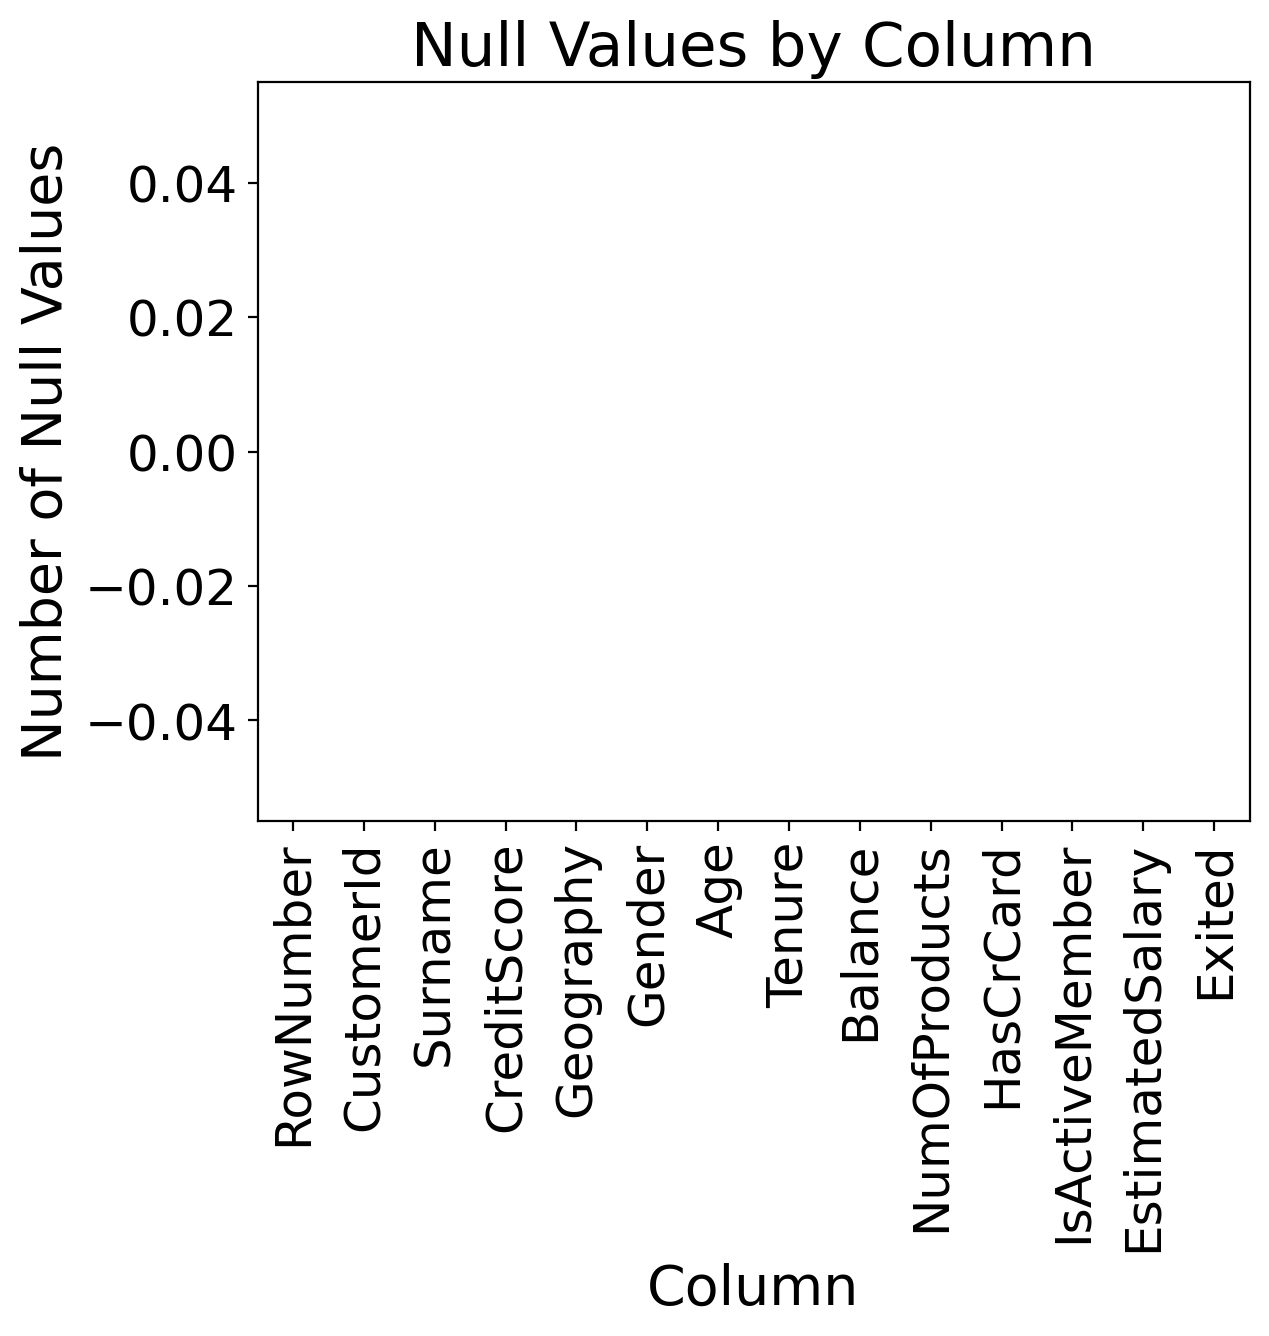

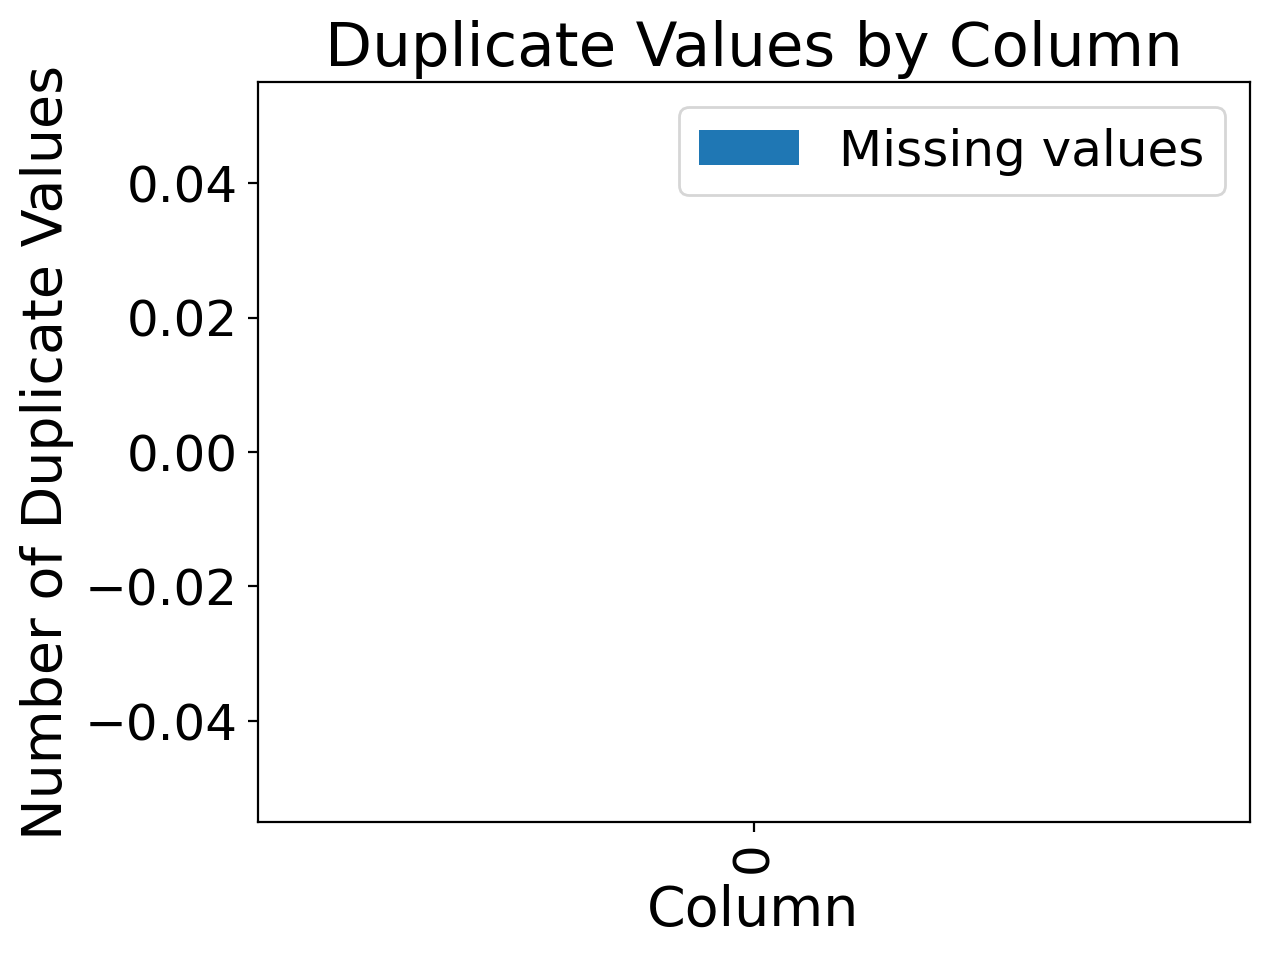

In [9]:
nulls_by_column = bankData.isnull().sum()
nulls_by_column.plot(kind='bar')

plt.title('Null Values by Column')
plt.xlabel('Column')
plt.ylabel('Number of Null Values')

plt.show()

missing_by_column = bankData.duplicated().sum()
missing_data = {'Missing values': missing_by_column}
missing_df = pd.DataFrame(missing_data, index=[0])  # Thêm chỉ mục index=[0]
missing_df.plot(kind='bar')

plt.title('Duplicate Values by Column')
plt.xlabel('Column')
plt.ylabel('Number of Duplicate Values')

plt.show()


### Bảng Mean, Mod, Phân vị

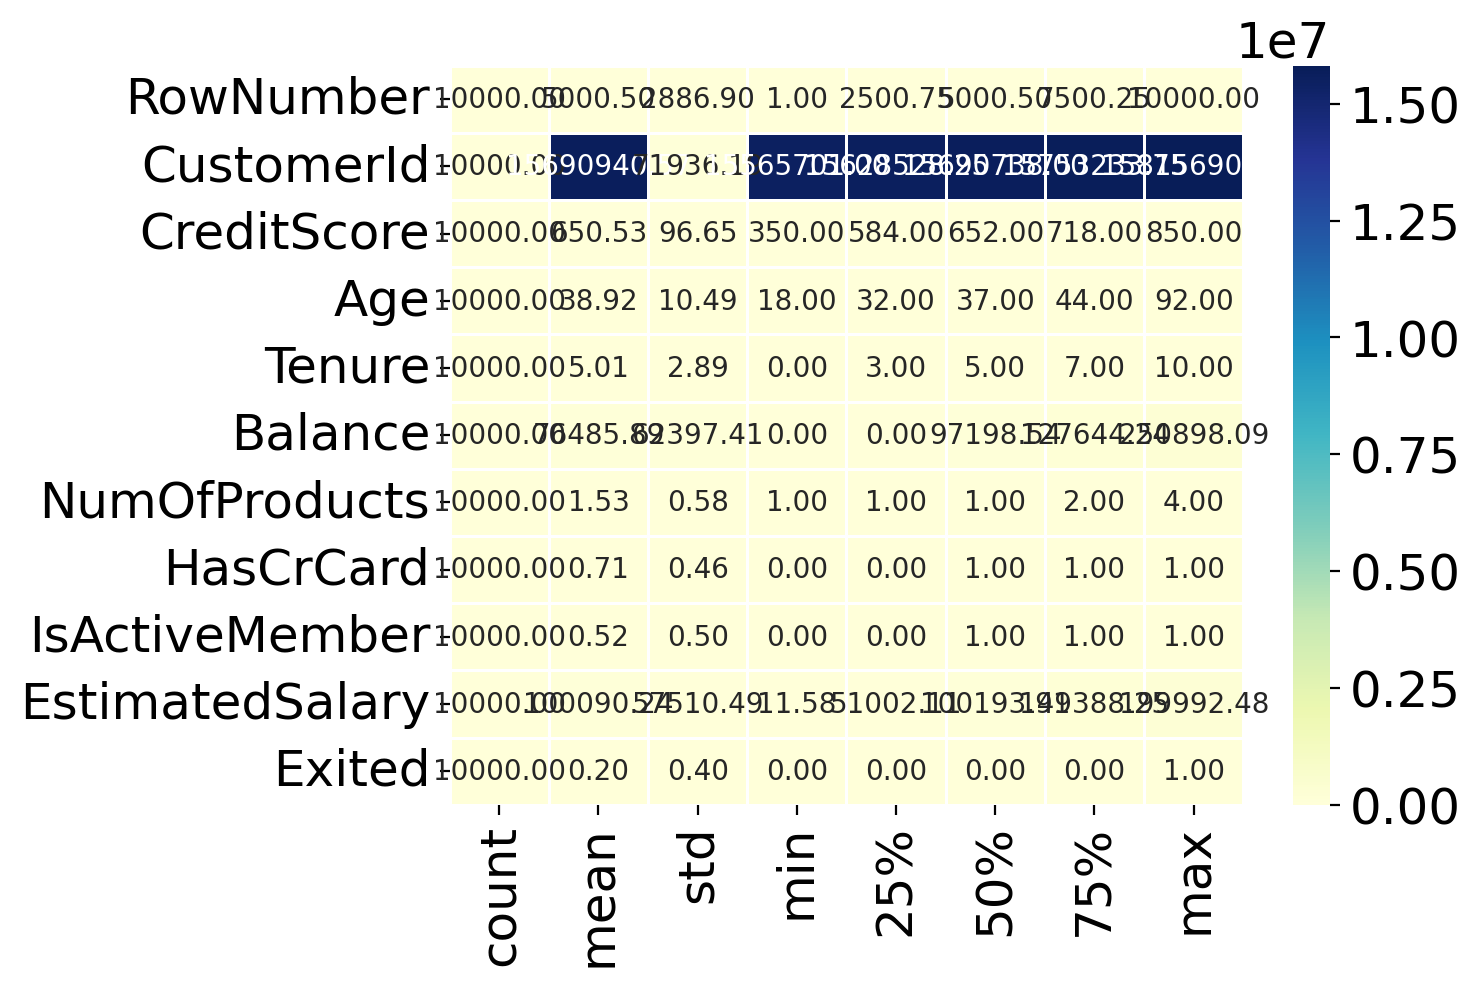

In [10]:
df_desc = bankData.describe().T
sns.heatmap(df_desc, annot=True, fmt=".2f",
             linewidths=1,
             linecolor="white",
             cmap="YlGnBu")
plt.show()

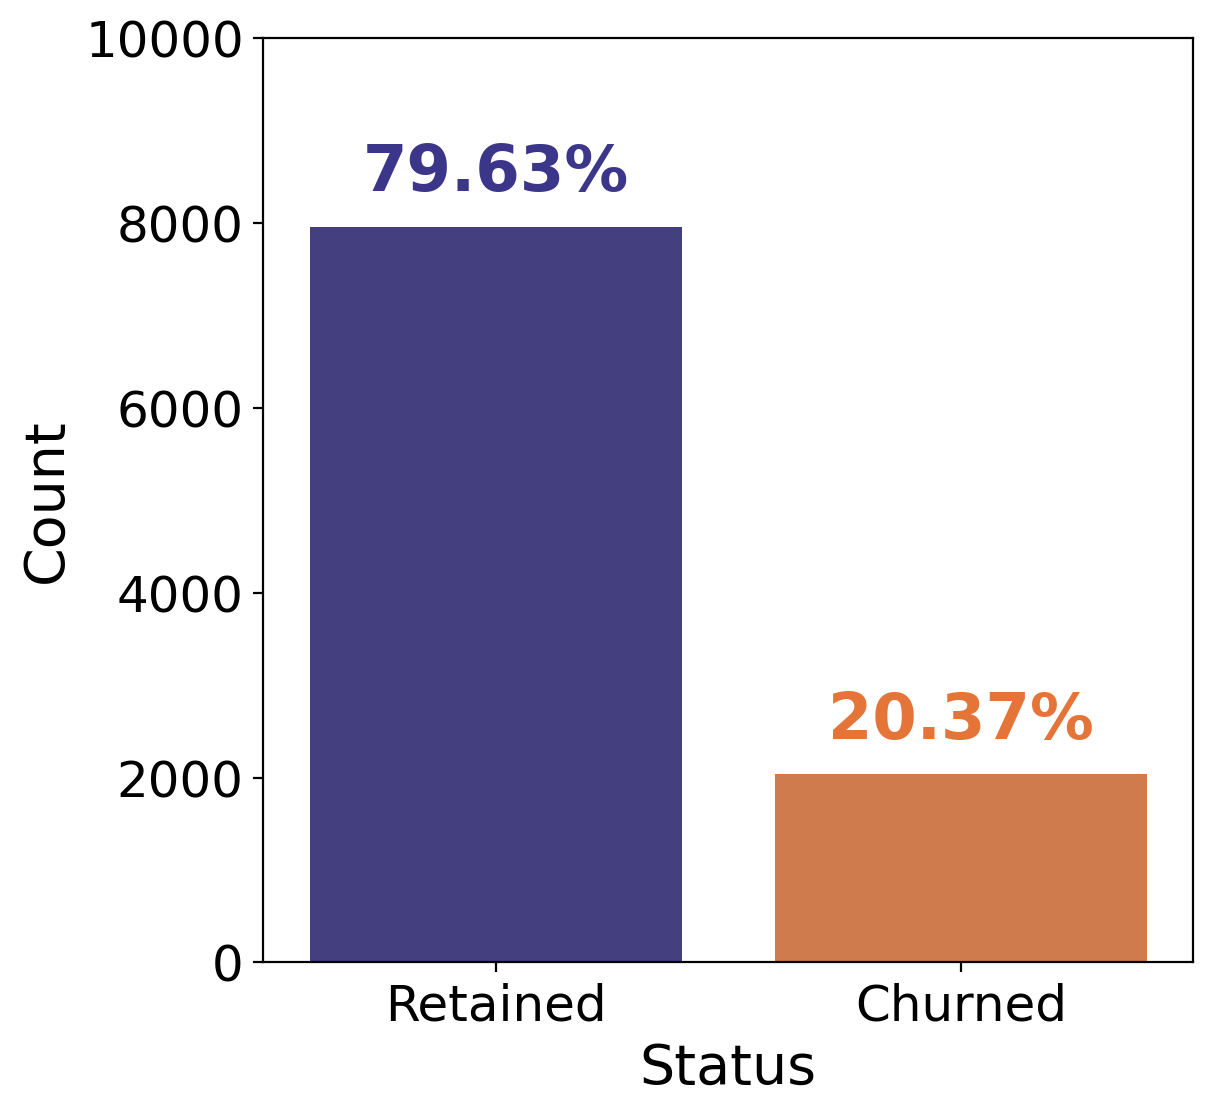

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.countplot(x='Exited', data=bankData, palette=colors, ax=ax)

for index, value in enumerate(bankData['Exited'].value_counts()):
    label = '{}%'.format(round((value / bankData['Exited'].shape[0]) * 100, 2))
    ax.annotate(label,
                xy=(index, value + 250),
                ha='center',
                va='bottom',
                color=colors[index],
                fontweight='bold',
                size=font_size + 3)
ax.set_xticklabels(['Retained', 'Churned'])
ax.set_xlabel('Status')
ax.set_ylabel('Count')
ax.set_ylim([0, 10000]);

In [12]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

print('Continuous: ', ', '.join(continuous))
print('Categorical: ', ', '.join(categorical))

Continuous:  Age, CreditScore, Balance, EstimatedSalary
Categorical:  Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember


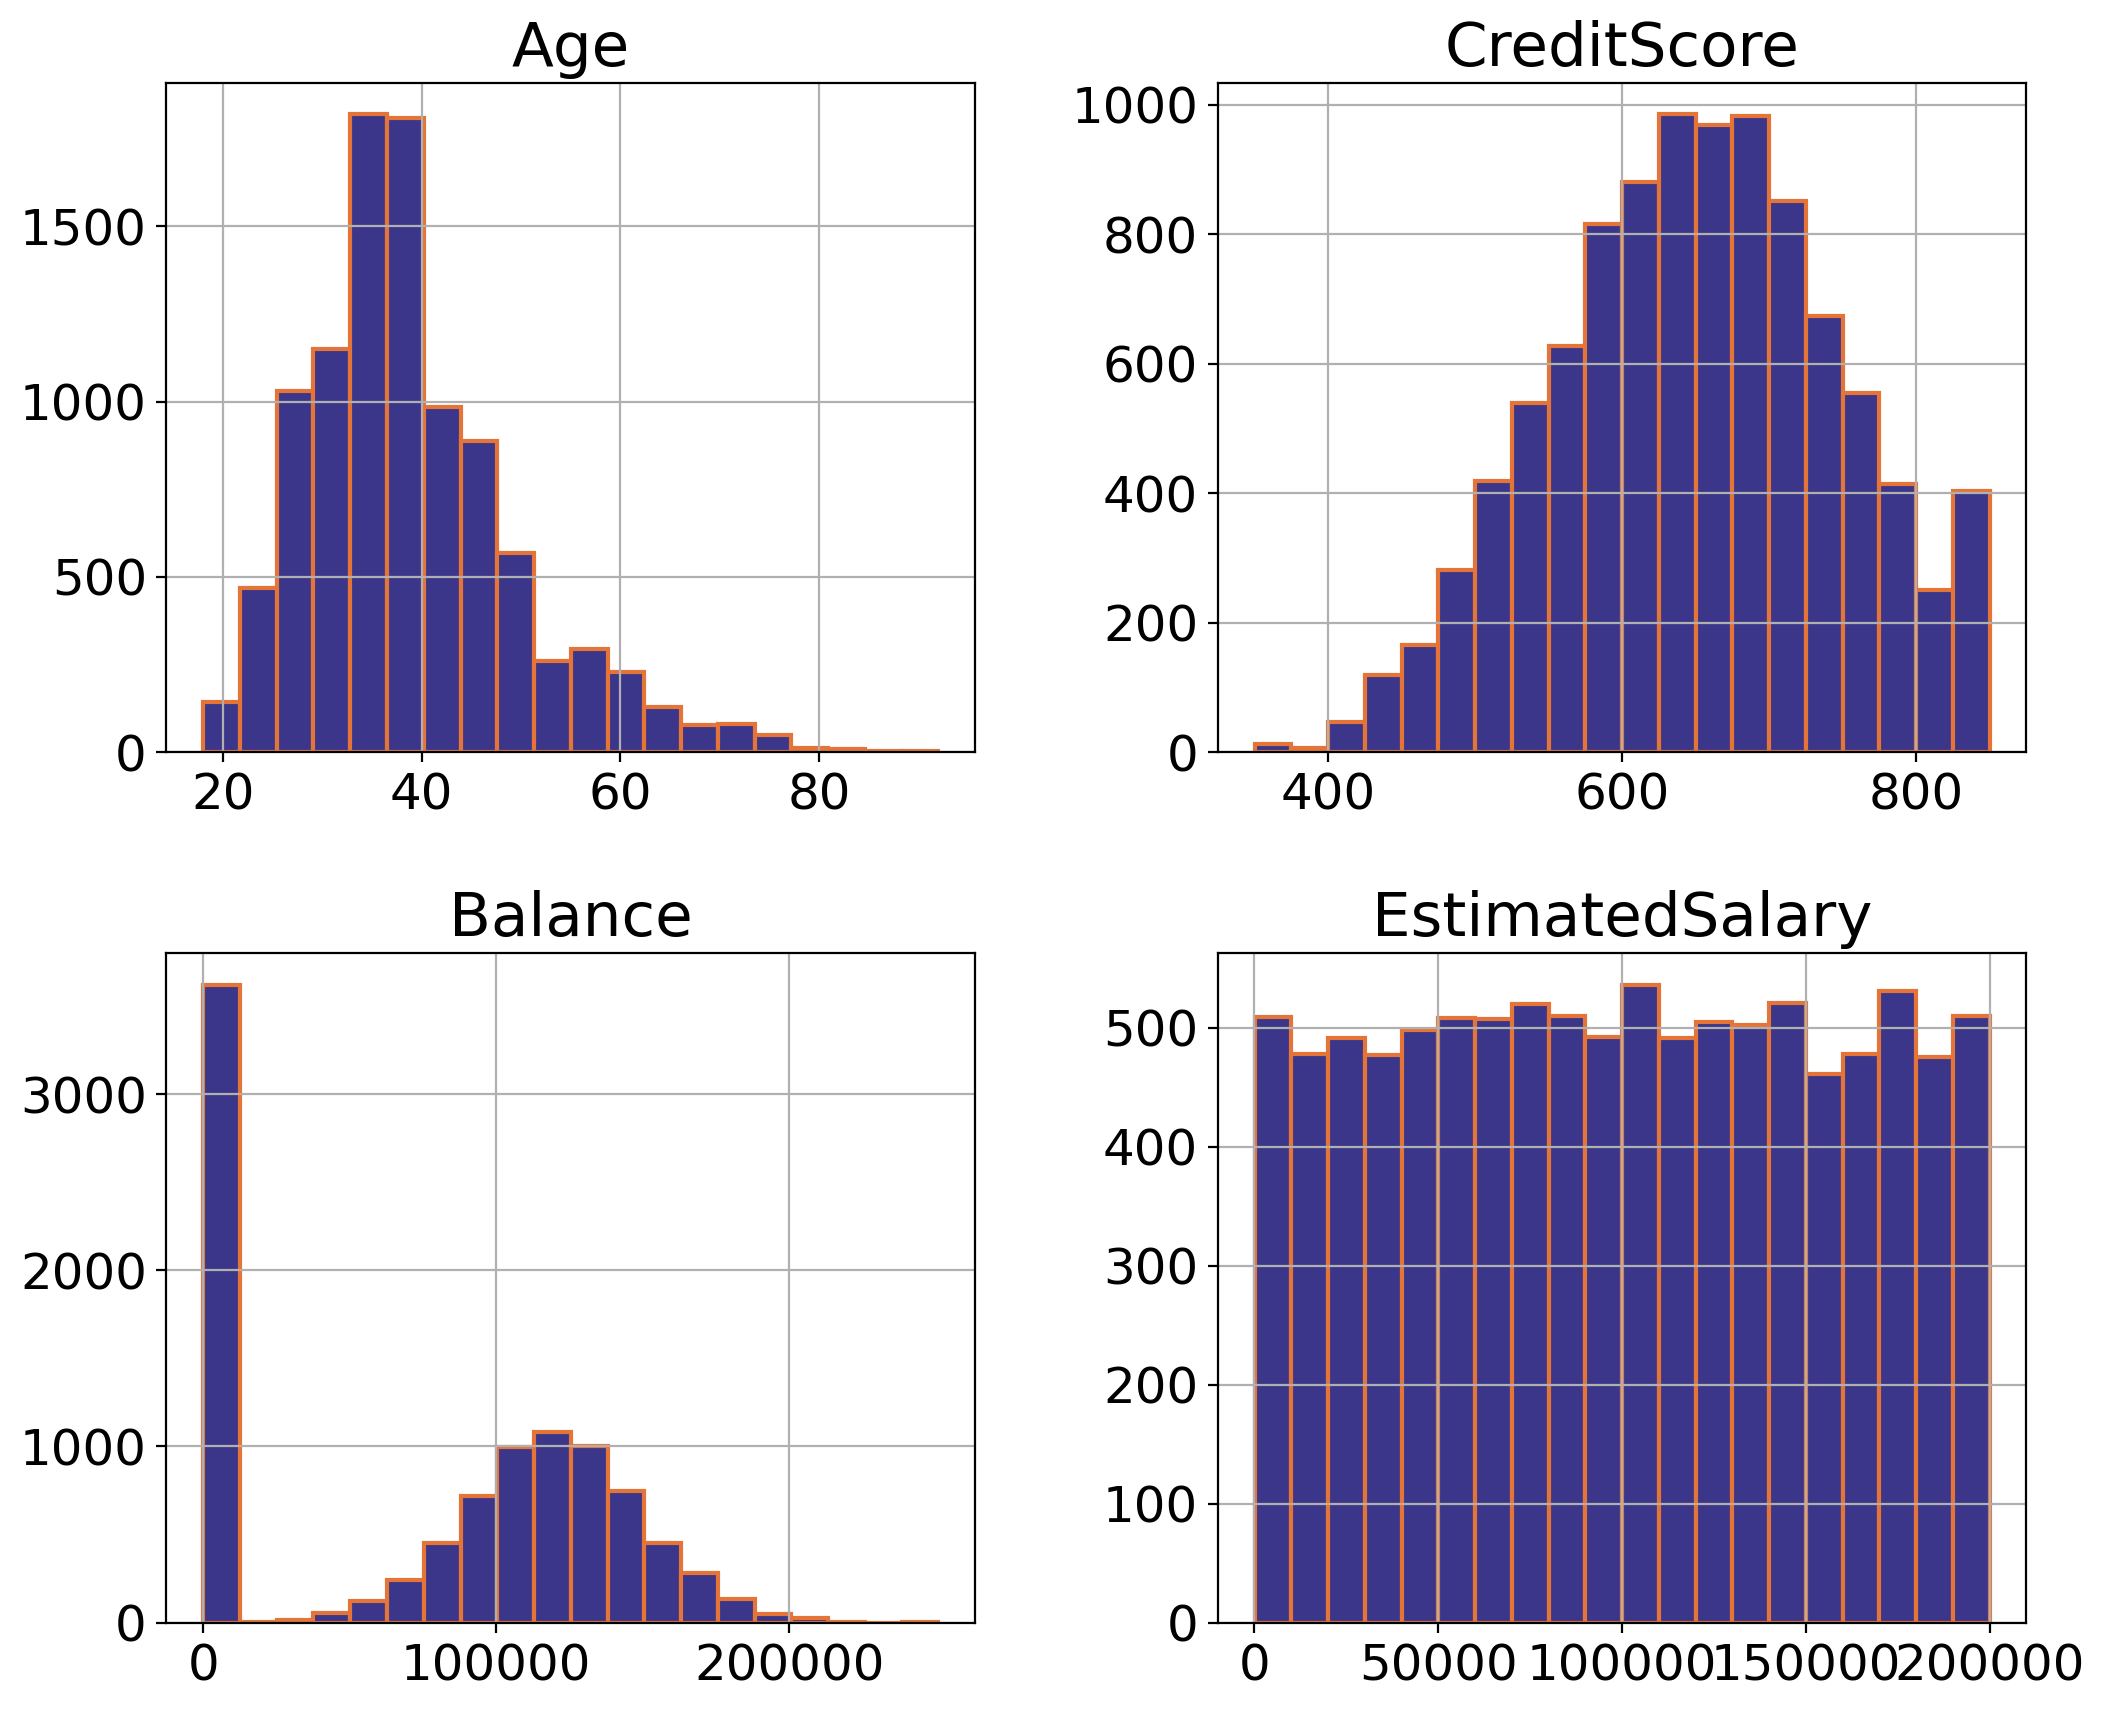

In [13]:
bankData[continuous].hist(figsize=(12, 10),
                          bins=20,
                          layout=(2, 2),
                          color='#3b3689',
                          edgecolor='#e57438',
                          linewidth=1.5);
# num_bins = 4
# bin_centers = 0.5*(bins[1:]+bins[:-1])
# for x,y in zip(bin_centers,n):
#     plt.text(x, y, round(x,1), ha='center')   


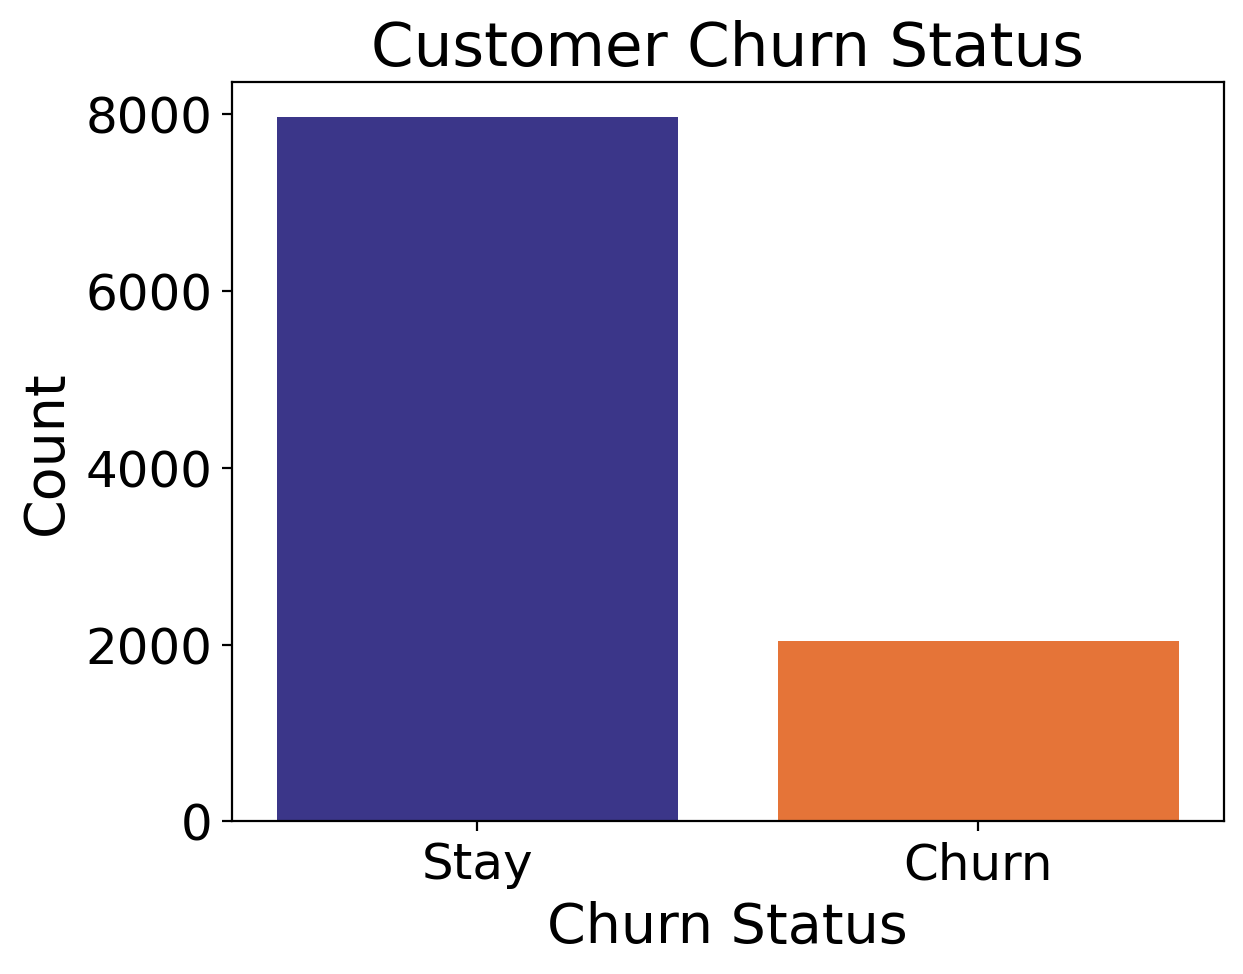

In [14]:
exited = bankData['Exited']
stay = exited[exited == 0].count()
churn = exited[exited == 1].count()
labels = ['Stay', 'Churn']
values = [stay, churn]
colors=['#3b3689','#e57438']
label = '{}%'.format(round((value / bankData['Exited'].shape[0]) * 100, 2))
plt.bar(x=labels,height=values,color=colors)
plt.title('Customer Churn Status')
plt.ylabel('Count')
plt.xlabel('Churn Status')
plt.show()

## Feature attributes

In [15]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']

### Age

In [16]:
def plot_continuous(feature):
  
    df_func = bankData.copy()
    df_func['Exited'] = df_func['Exited'].astype('category')
    
    fig, (ax1, ax2) = plt.subplots(2,
                                   figsize=(9, 7),
                                   sharex=True,
                                   gridspec_kw={'height_ratios': (.7, .3)})
    for df,color, label in zip([df_retained, df_churned], colors, ['Retained', 'Churned']):
        sns.histplot(data=df,
                     x=feature,
                     bins=15,
                     color='#3b3689',
                     alpha=0.66,
                     edgecolor='#e57438',
                     label=label,
                     kde=False,
                     ax=ax1)
    ax1.legend()

    sns.boxplot(x=feature, y='Exited', data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Retained', 'Churned'])

    plt.tight_layout();


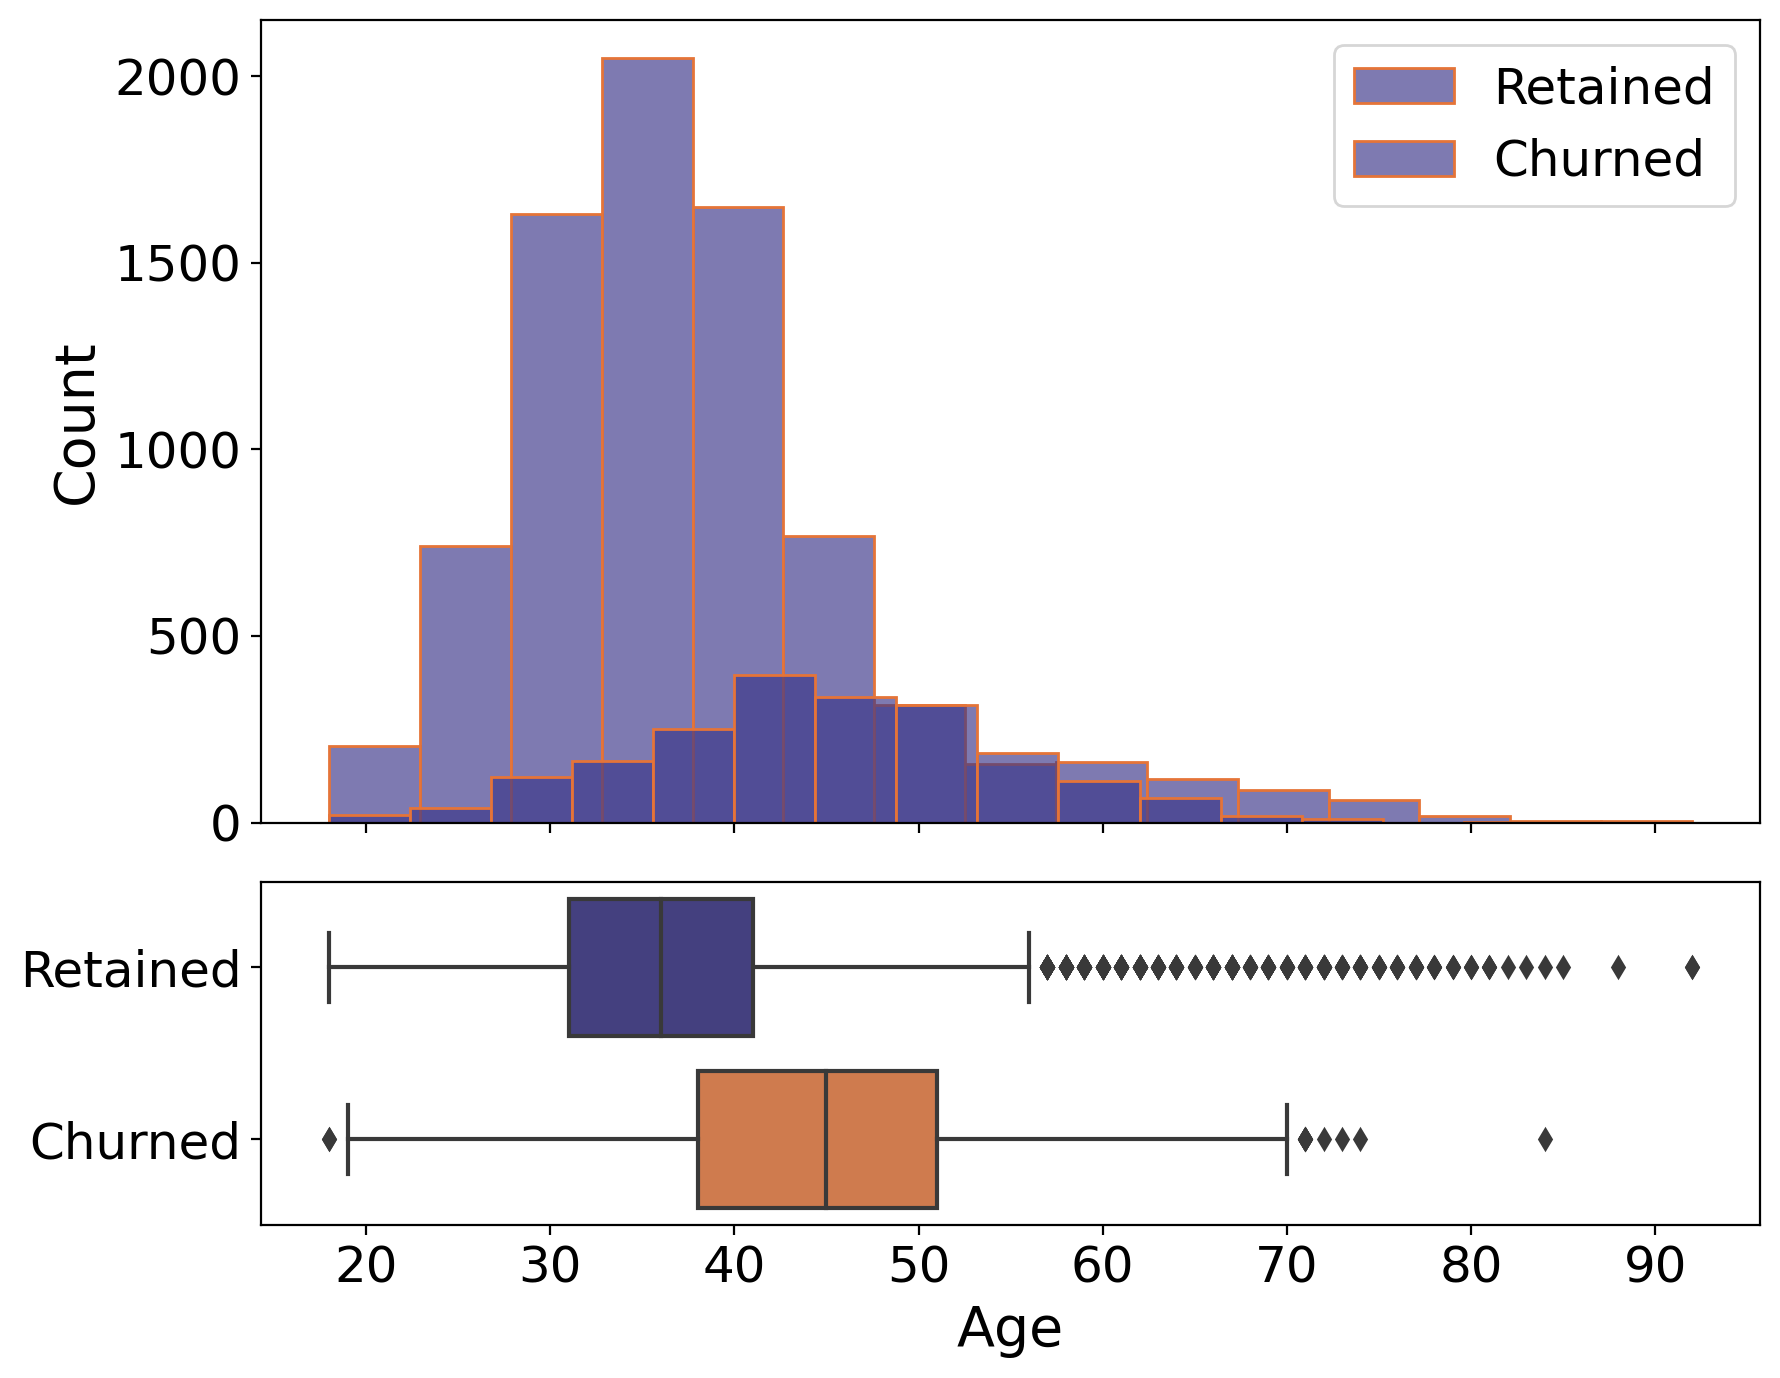

In [17]:
df_churned = bankData[bankData['Exited'] == 1]
df_retained = bankData[bankData['Exited'] == 0]

plot_continuous('Age')

### Credit Score

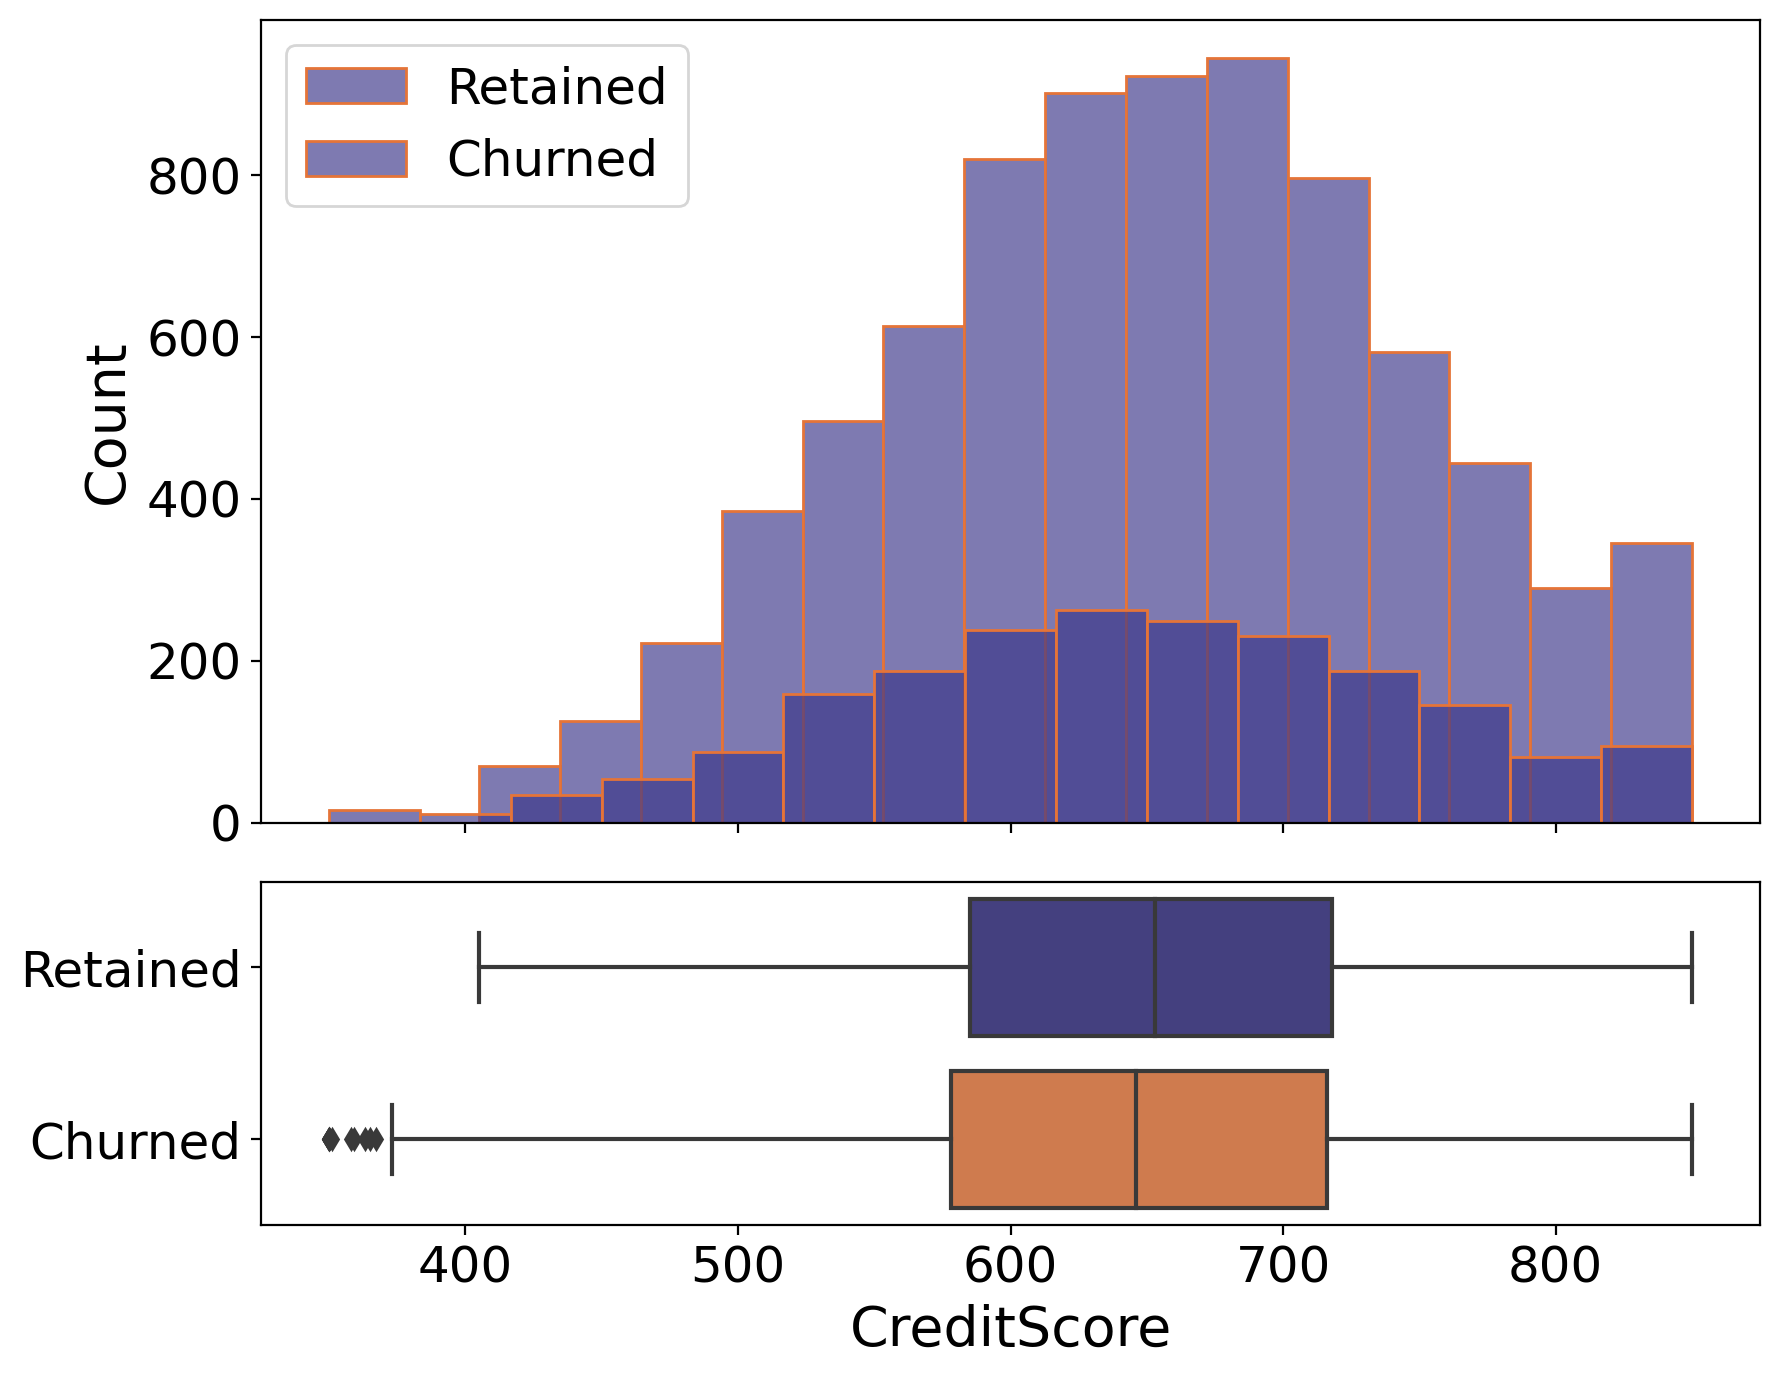

In [18]:
plot_continuous('CreditScore')

### Balance

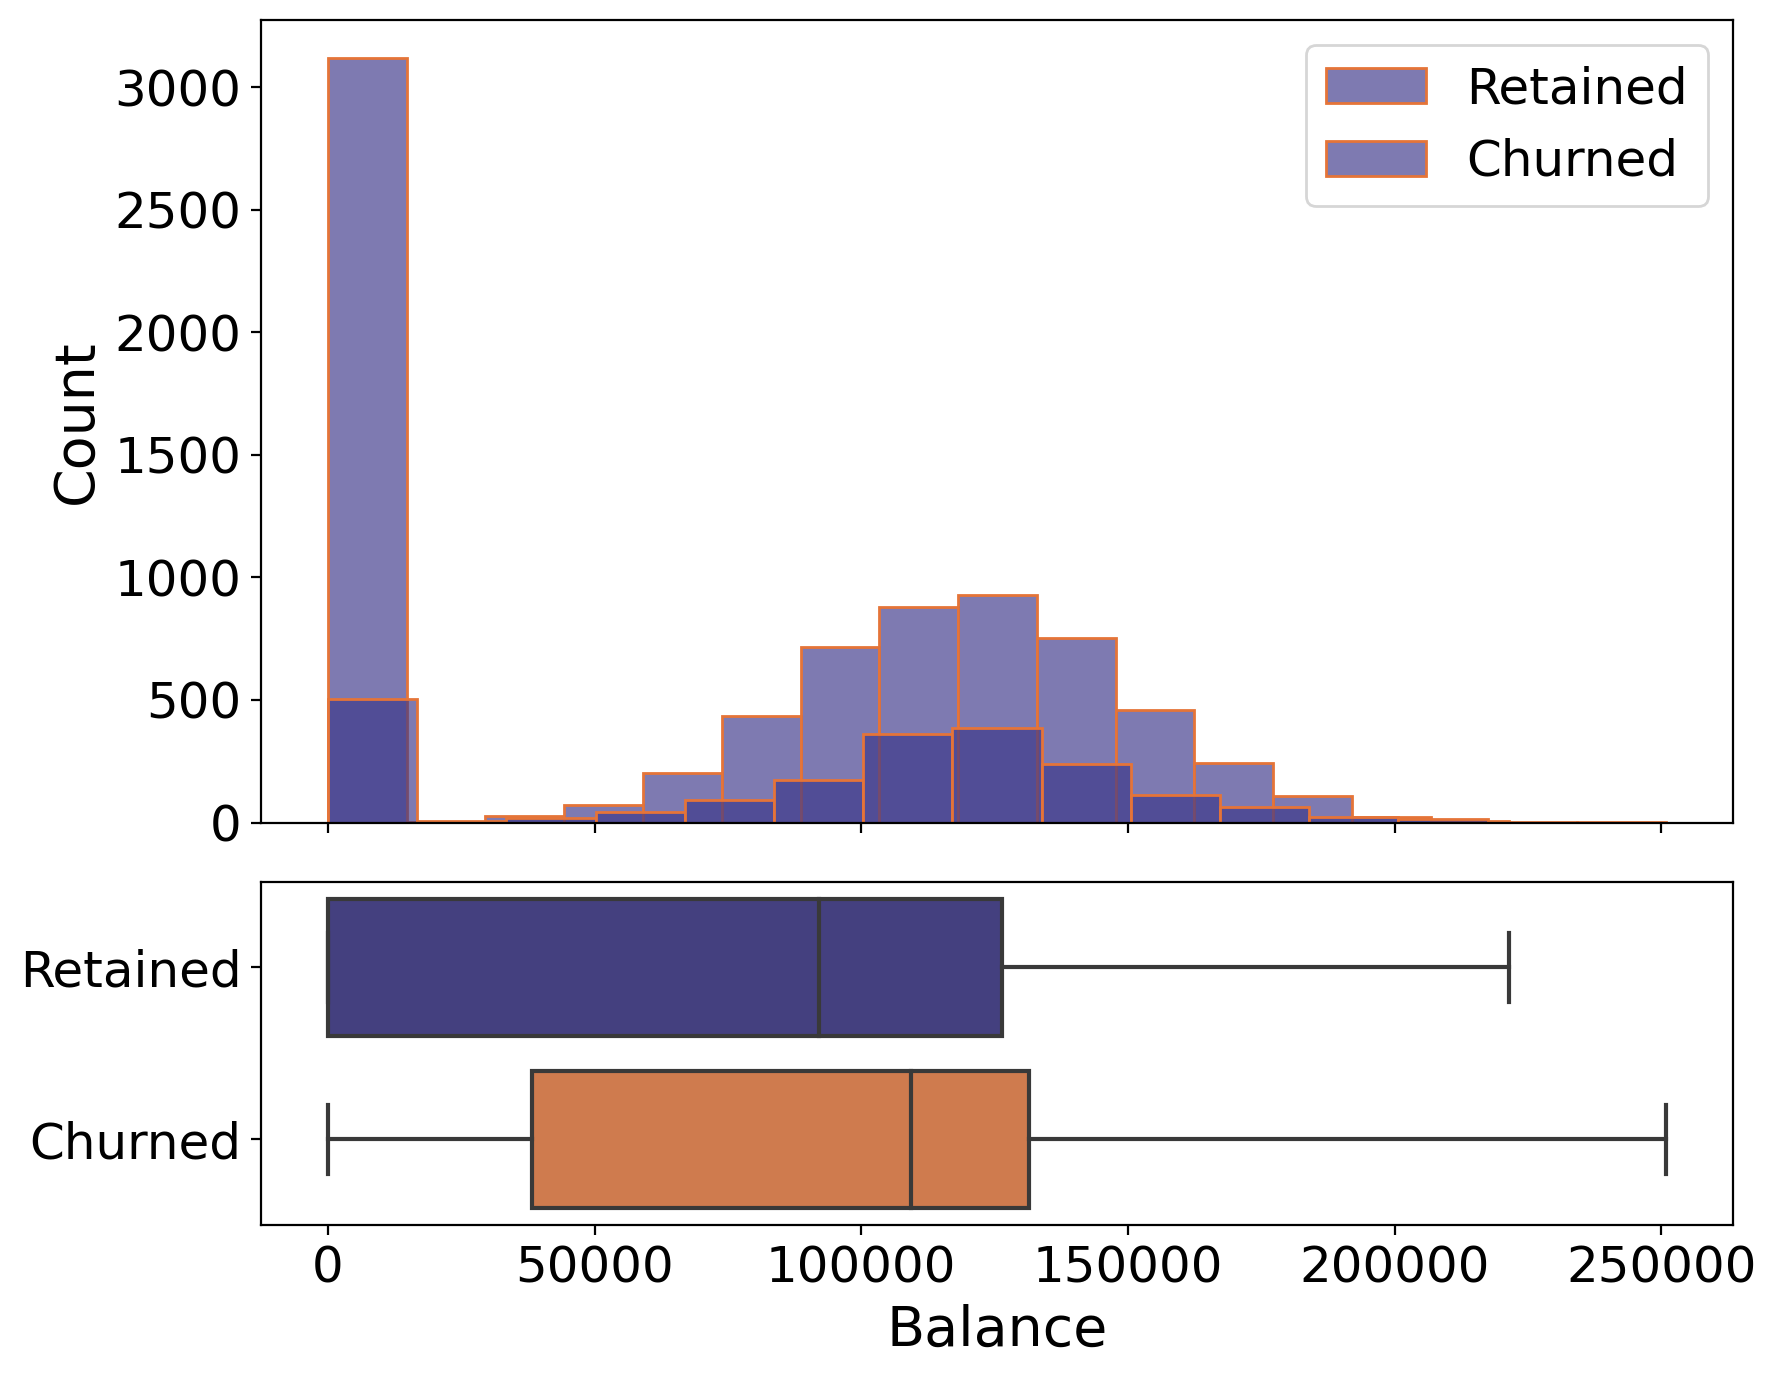

In [19]:
plot_continuous('Balance')

### Estimated Salary

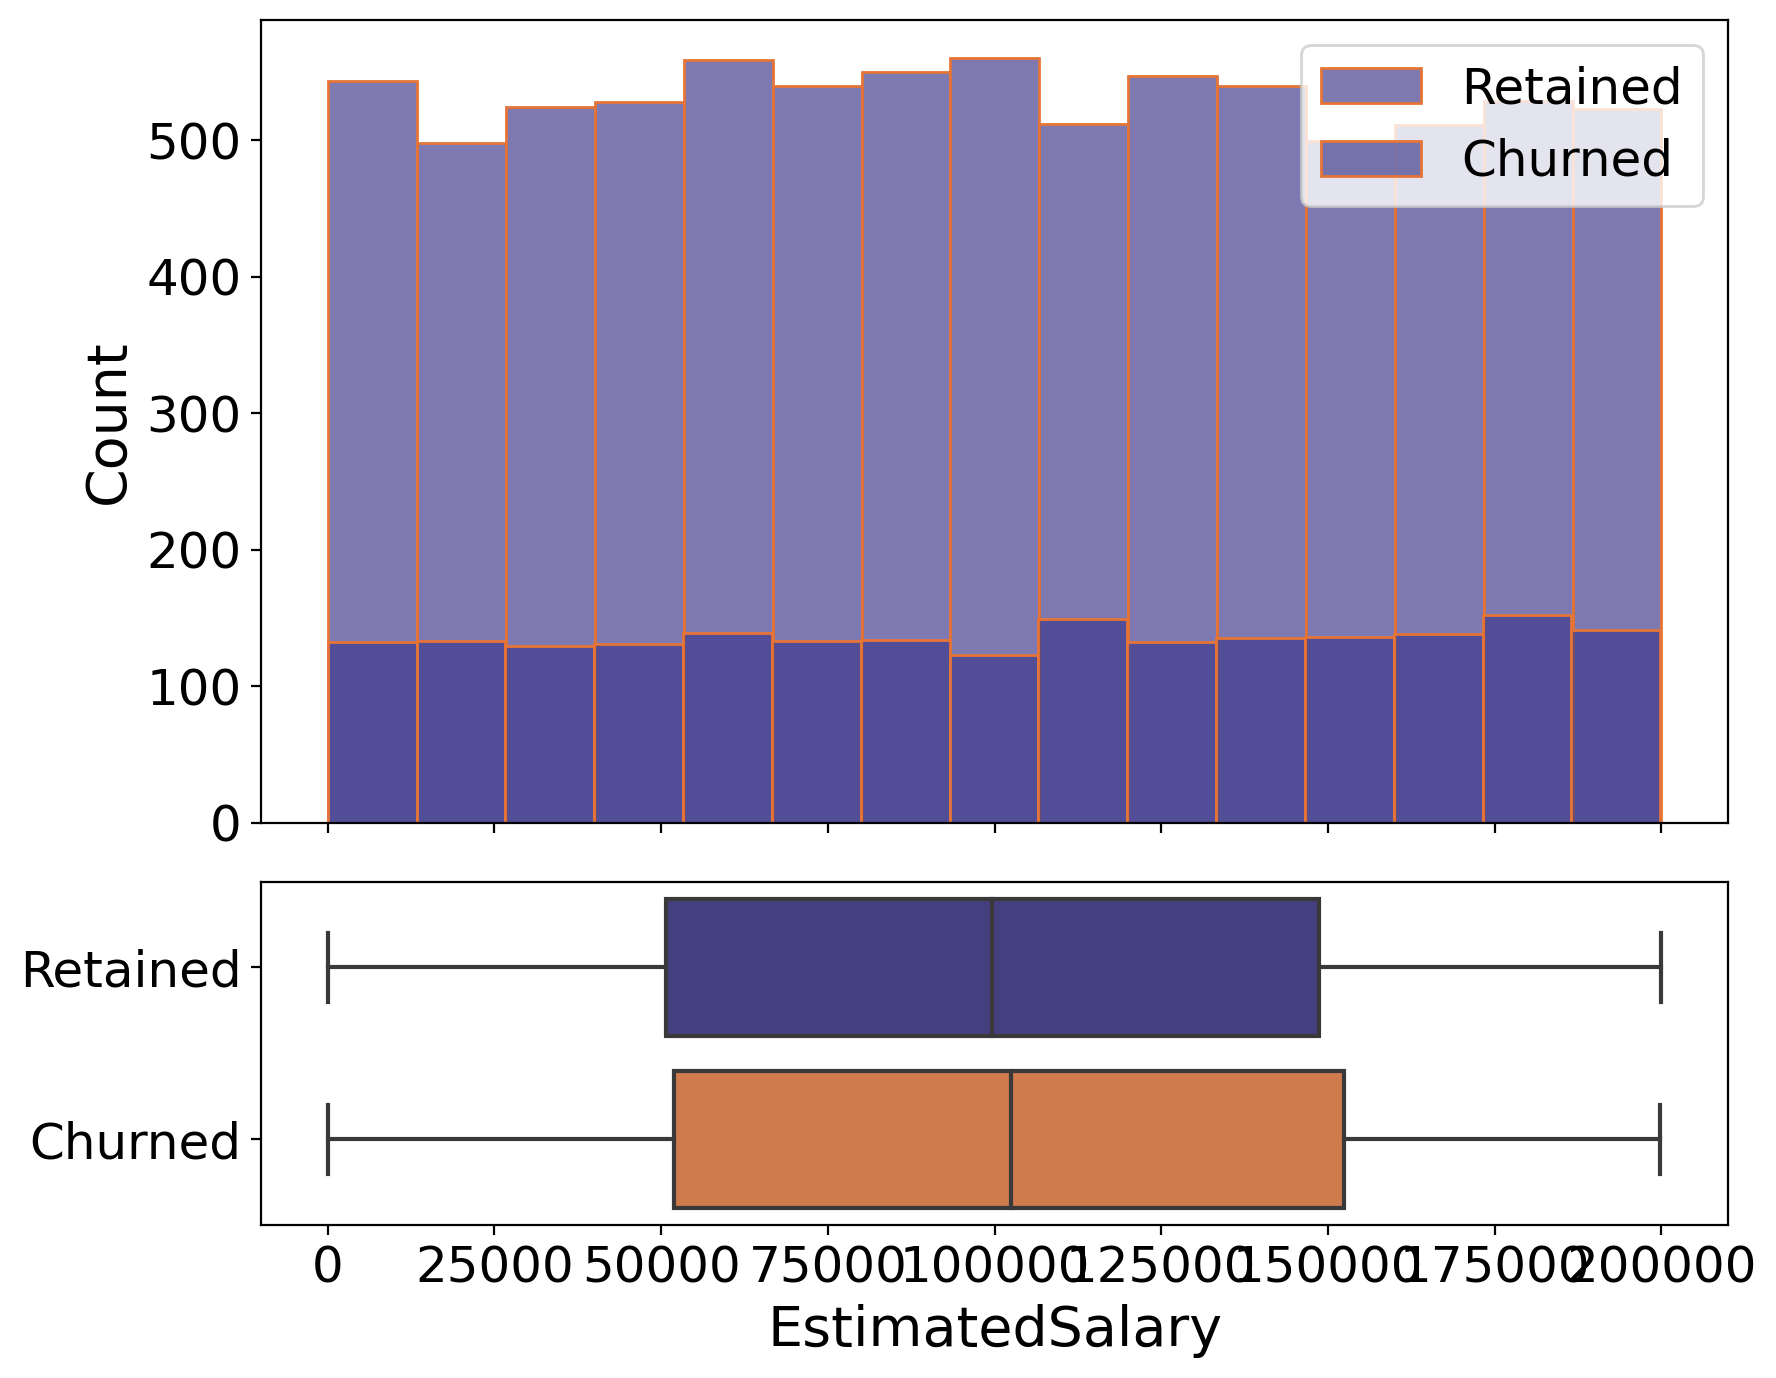

In [20]:
plot_continuous('EstimatedSalary')

## Categorical Variables

In [21]:
categorical= ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

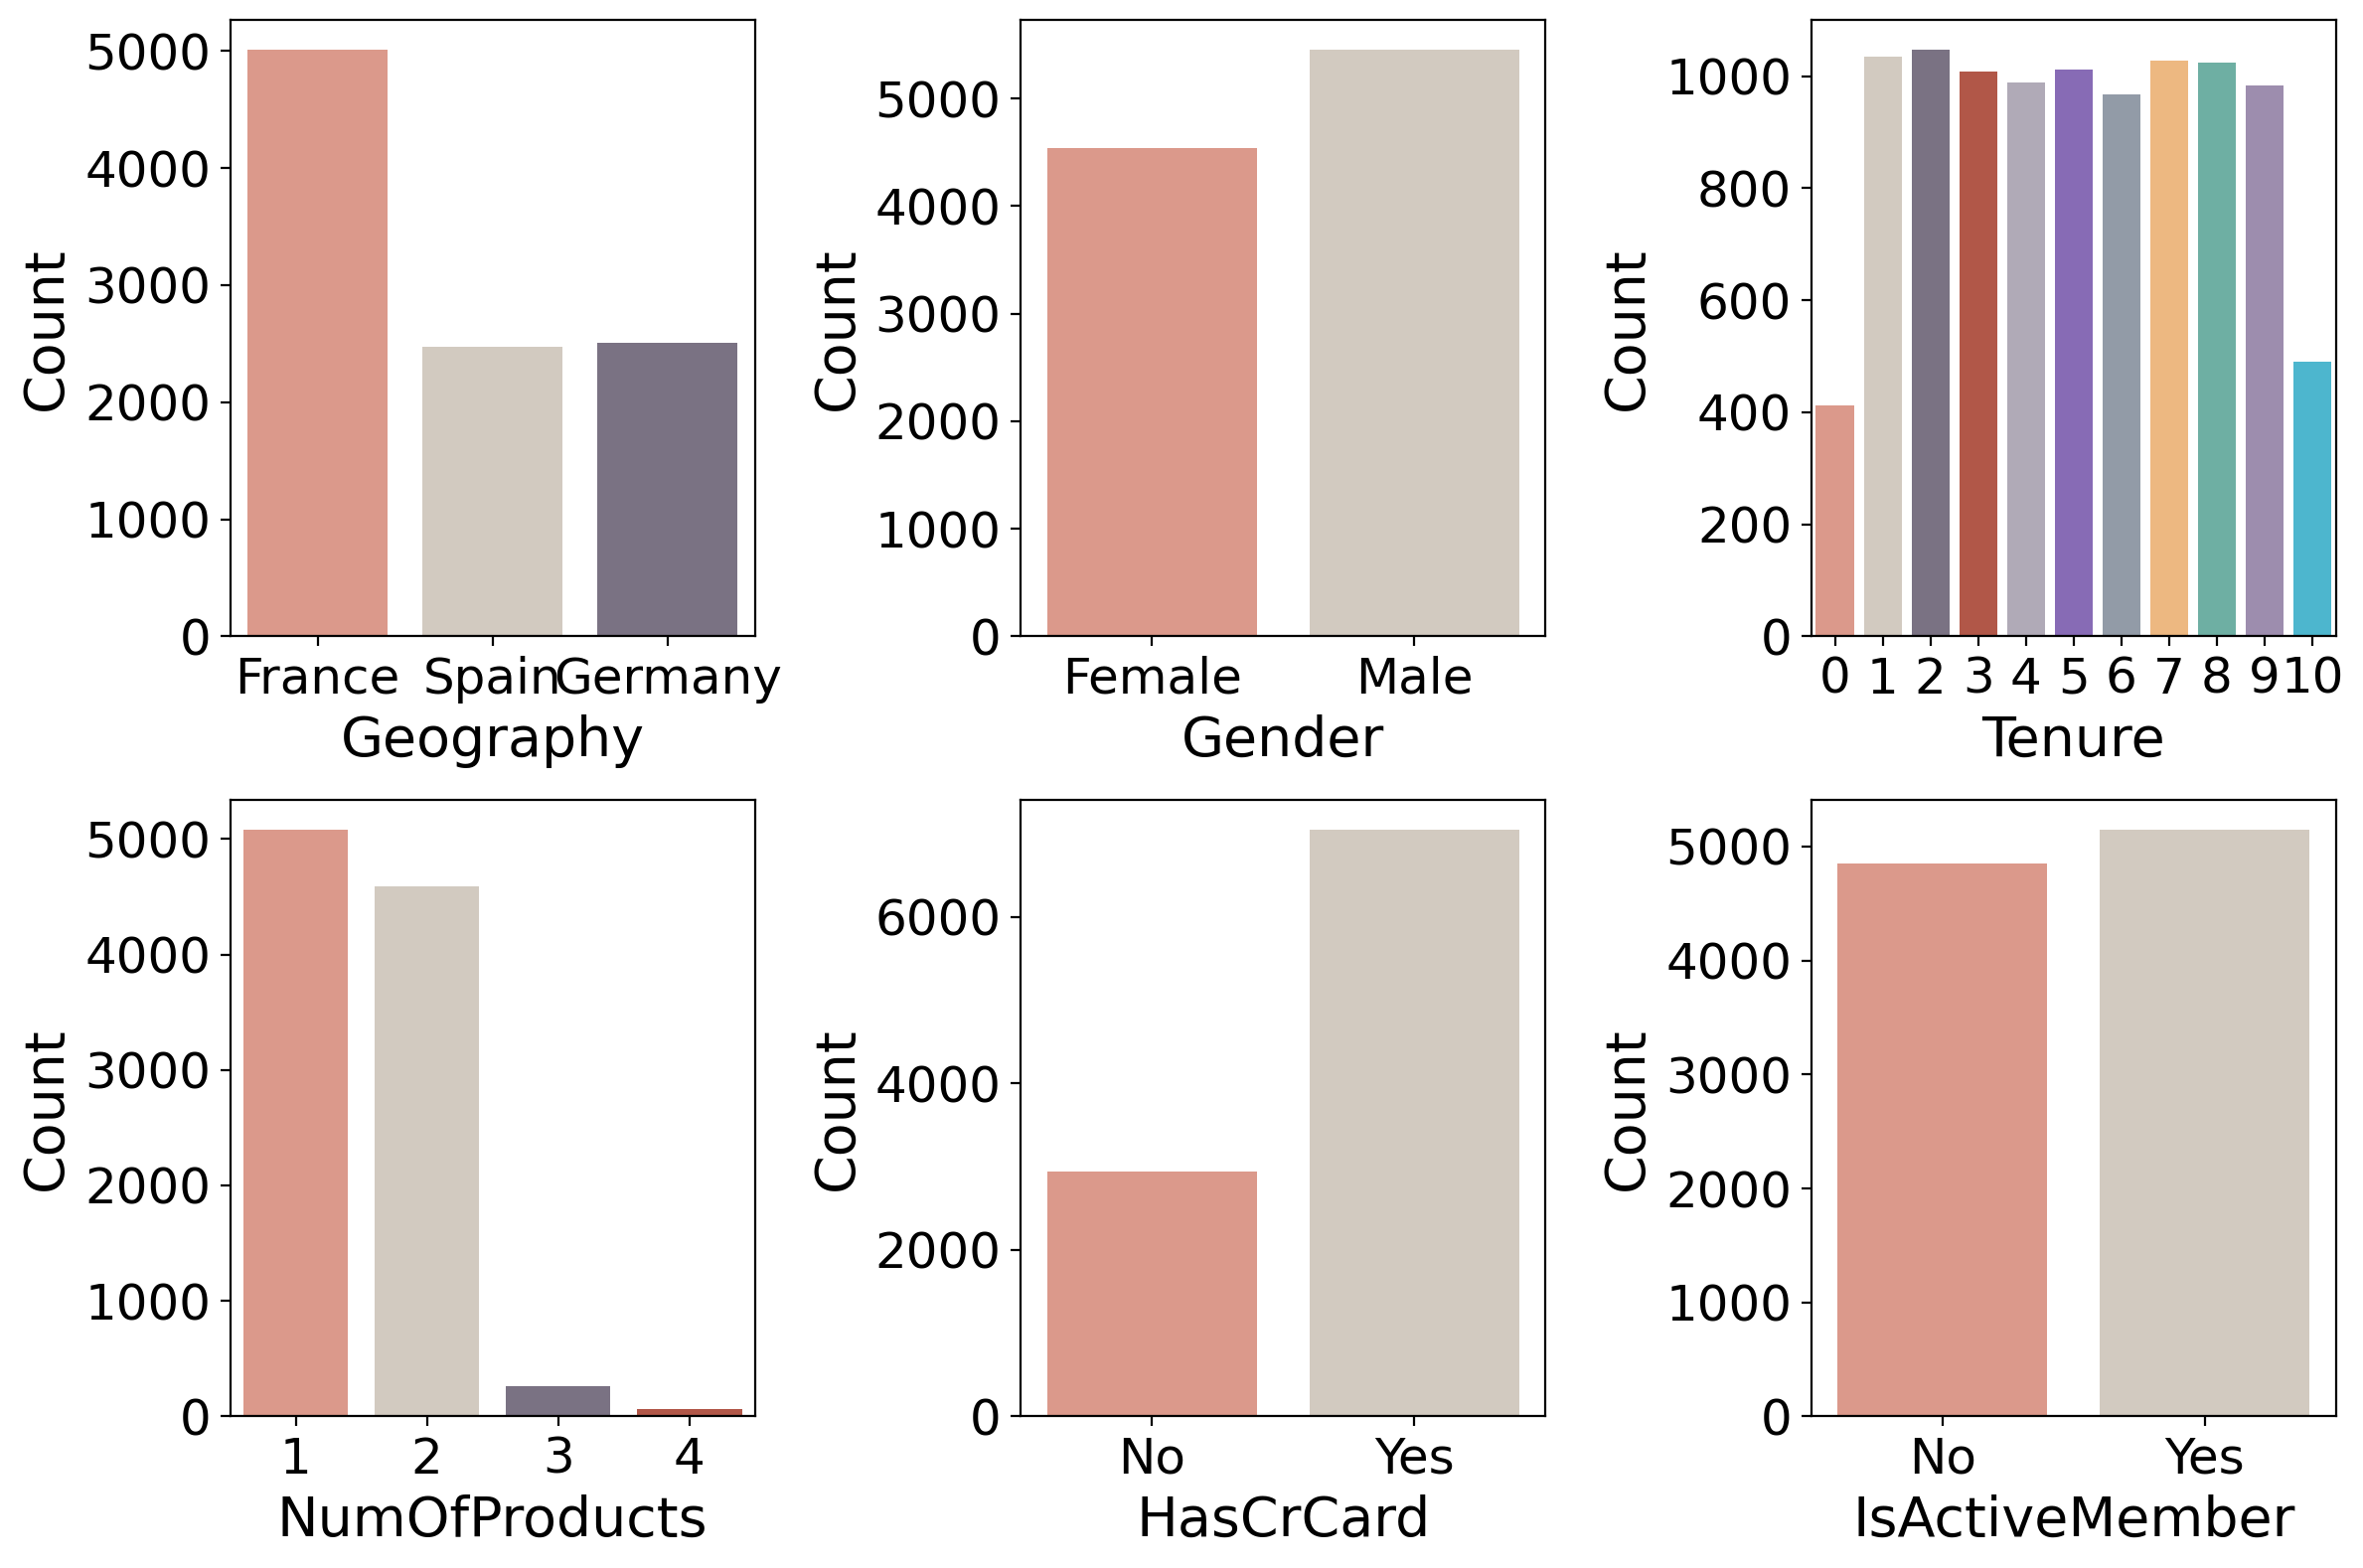

In [22]:
df_cat = bankData[categorical]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x=column, data=bankData, palette=colors_cat)

    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'):
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();

### Geography

In [30]:
def plot_categorical(feature):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))       
    sns.countplot(x=feature,
                  hue='Exited',
                  data=bankData,
                  palette=colors,
                  ax=ax1)
    ax1.set_ylabel('Count')
    ax1.legend(labels=['Retained', 'Churned'])

    sns.barplot(x=feature,
                y='Exited',
                data=bankData,
                palette=colors_cat,
                ax=ax2)
    ax2.set_ylabel('Churn rate')

    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])

    plt.tight_layout()


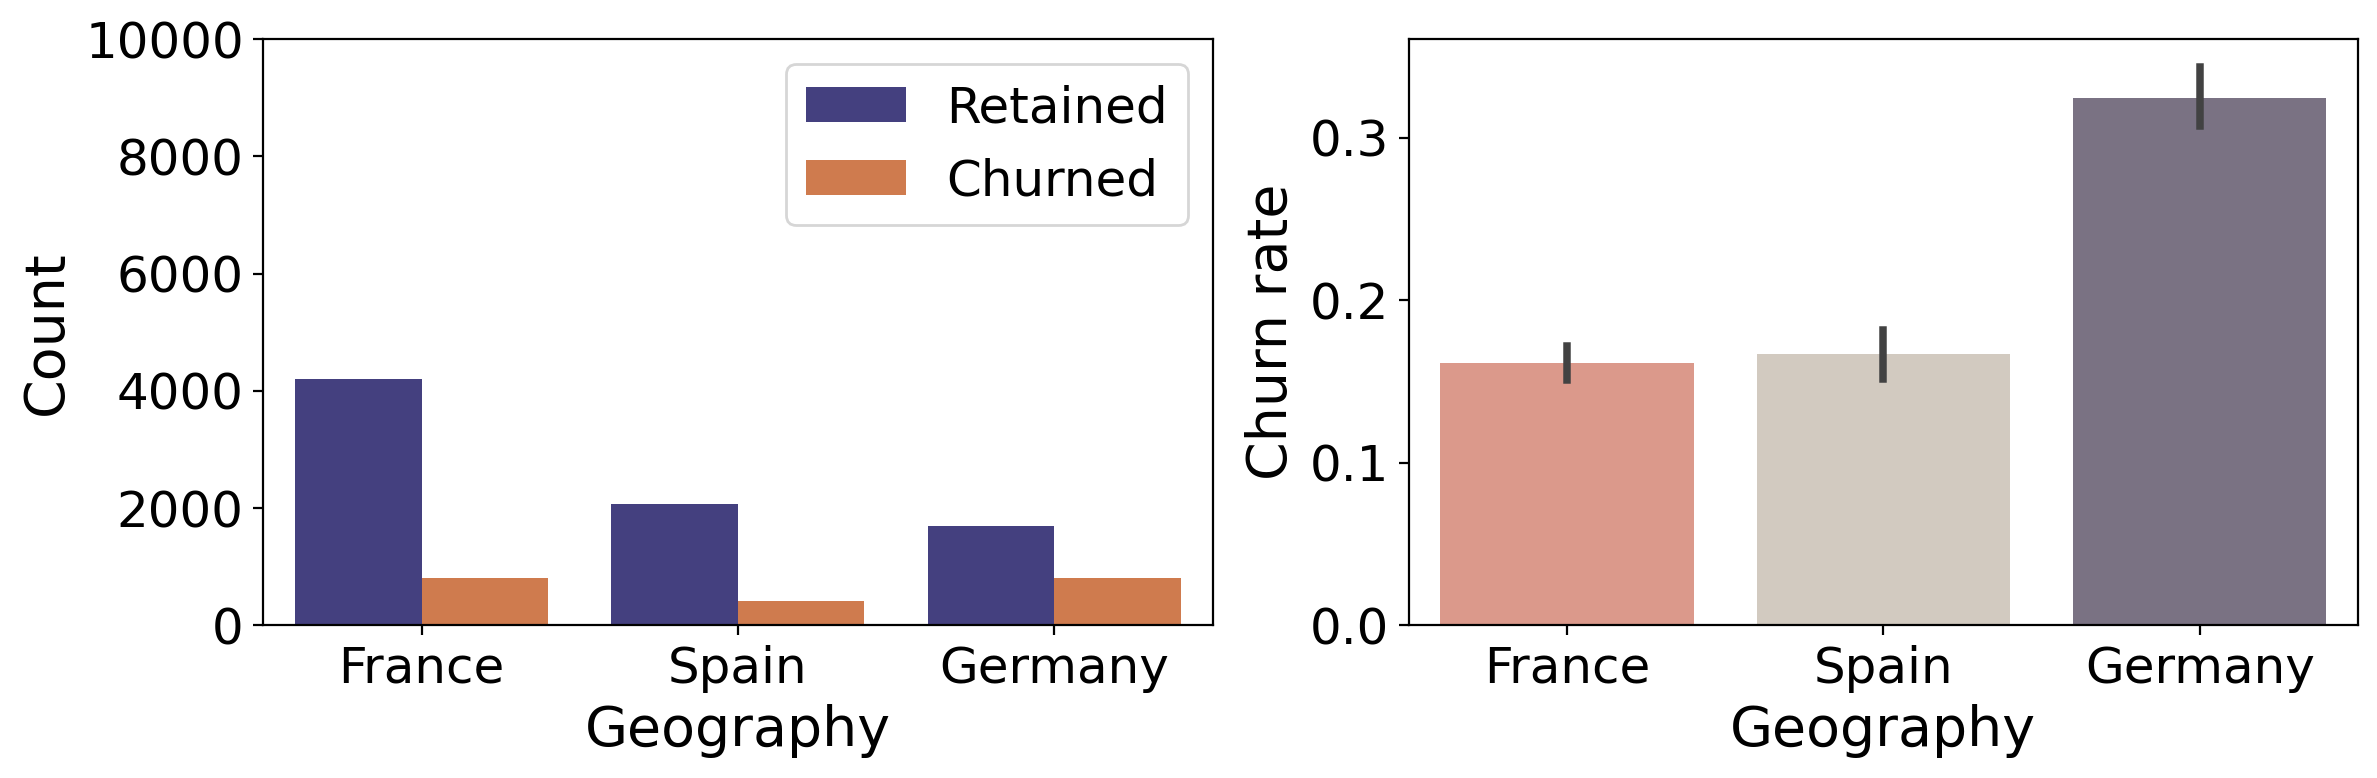

In [31]:
plot_categorical('Geography')

### Gender

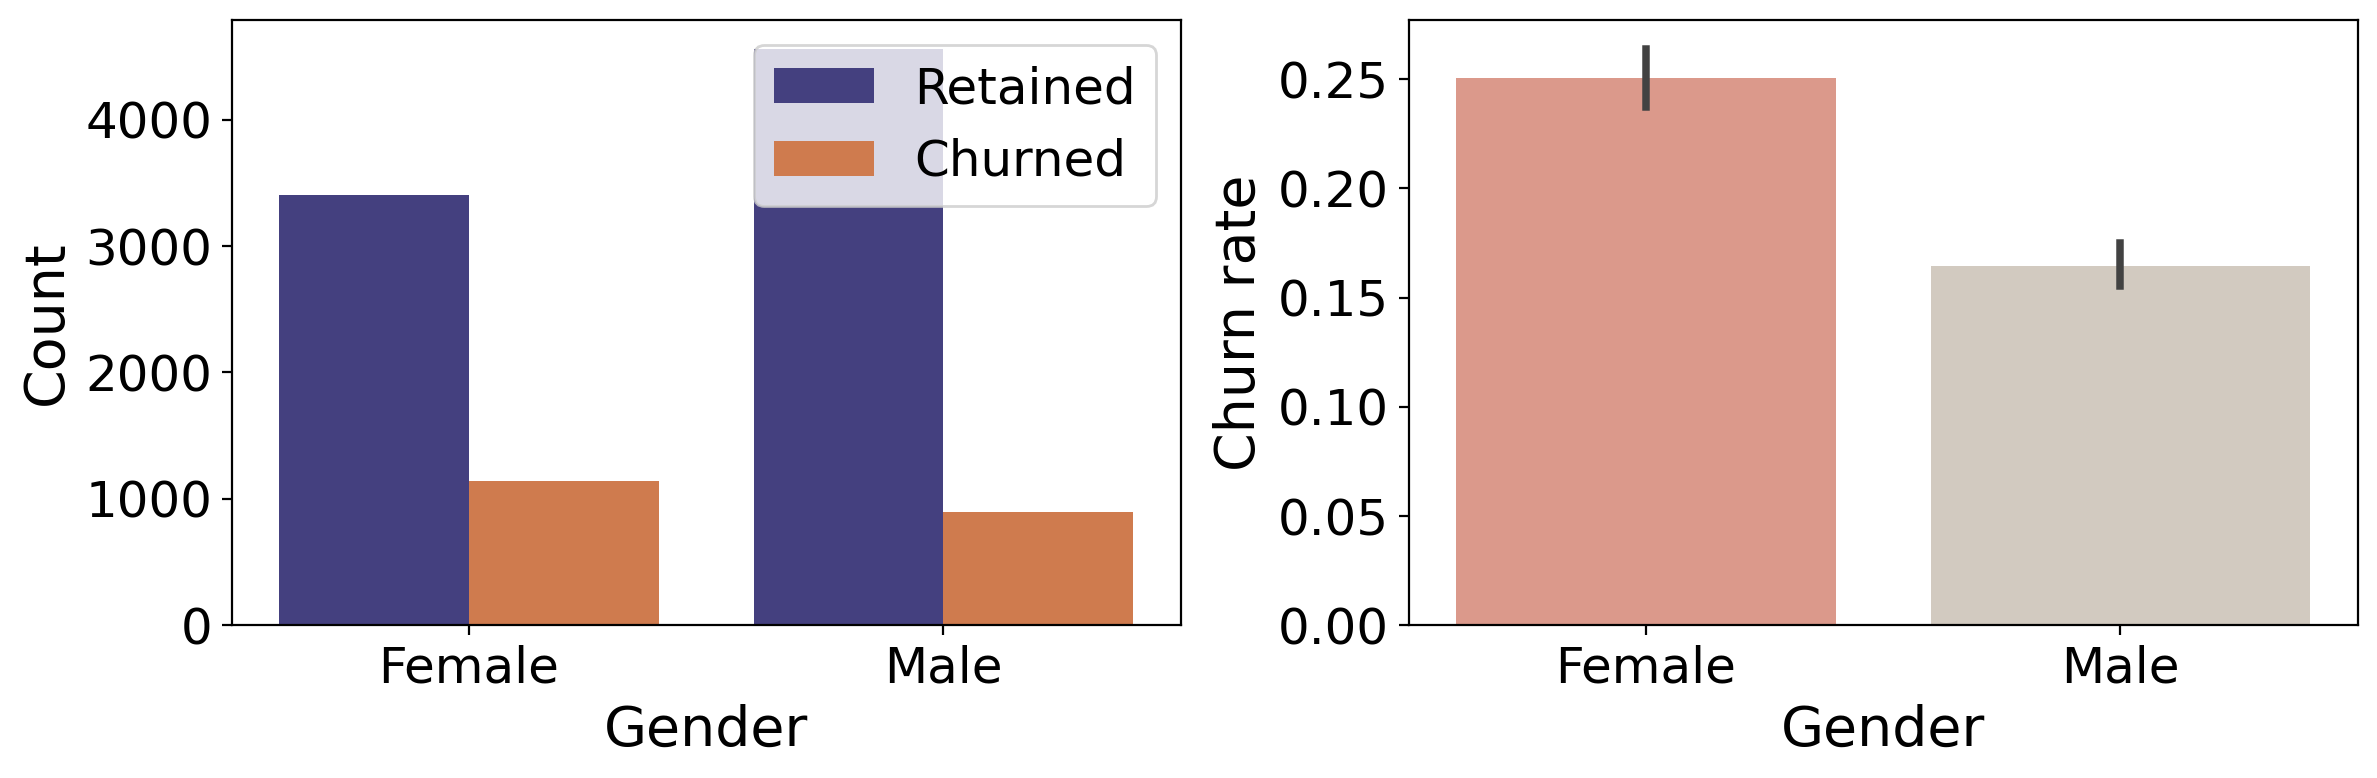

In [ ]:
plot_categorical('Gender')

### Tenure

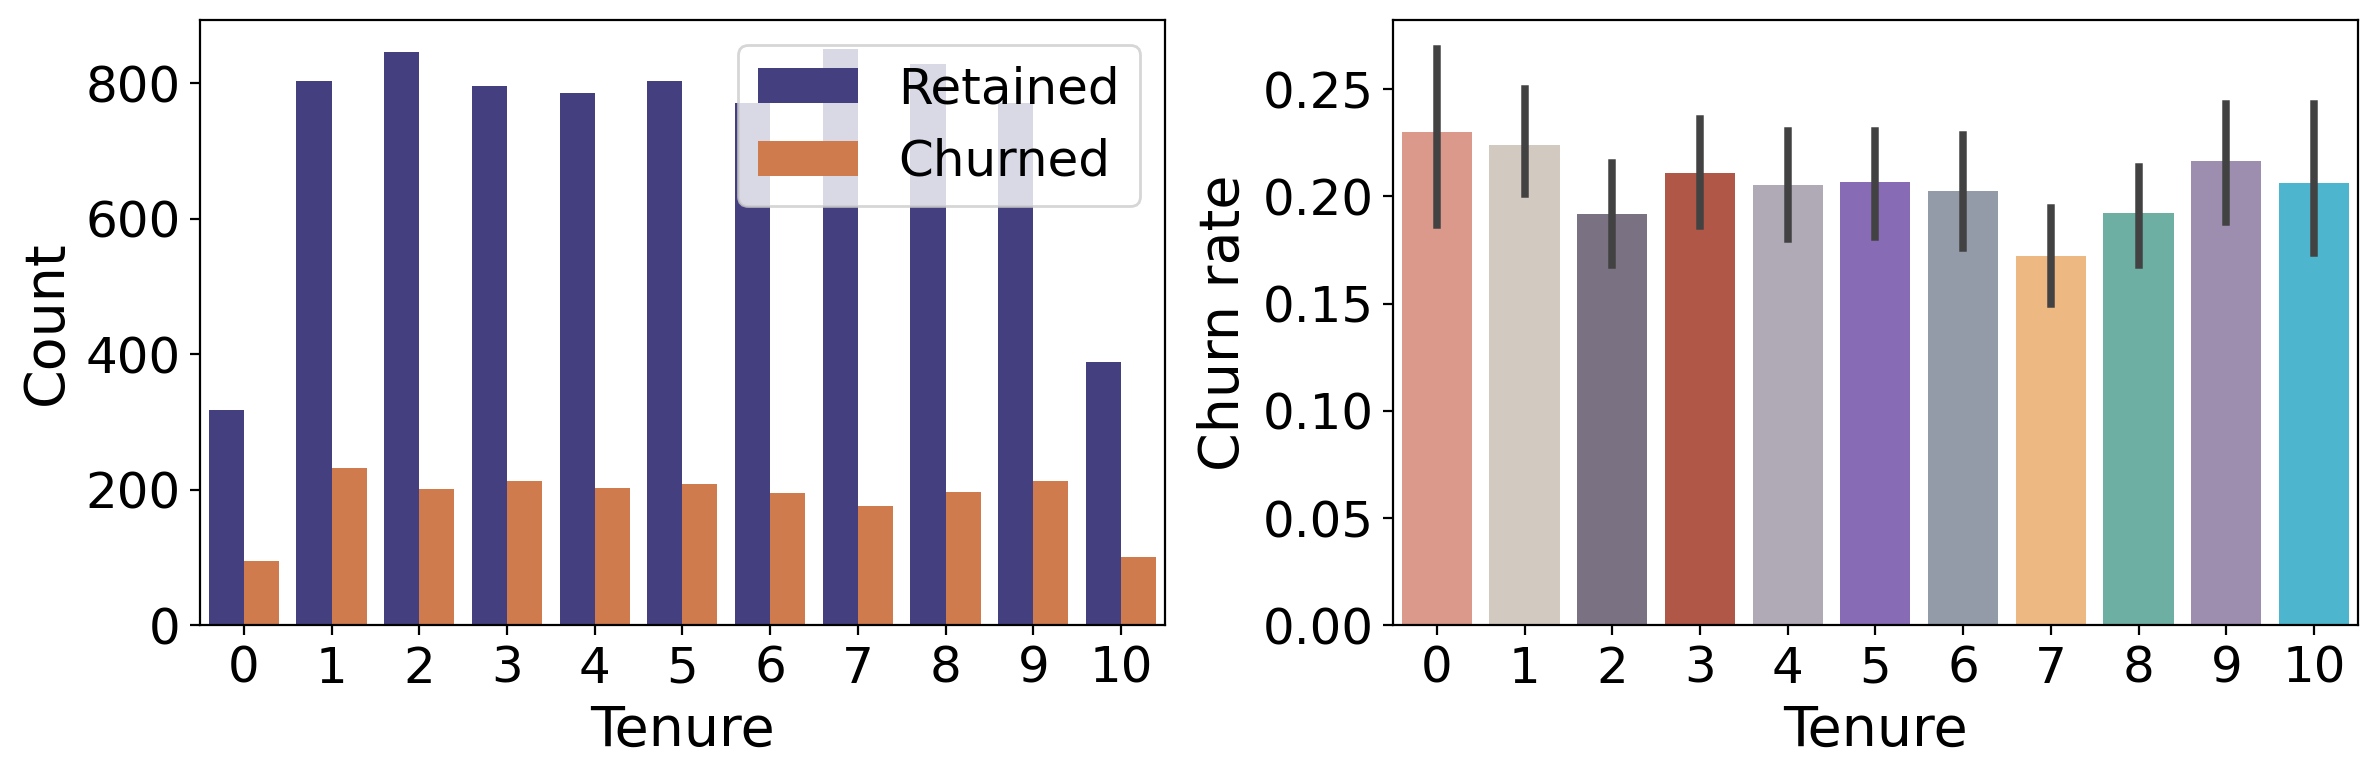

In [ ]:
plot_categorical('Tenure')

### Number of Product

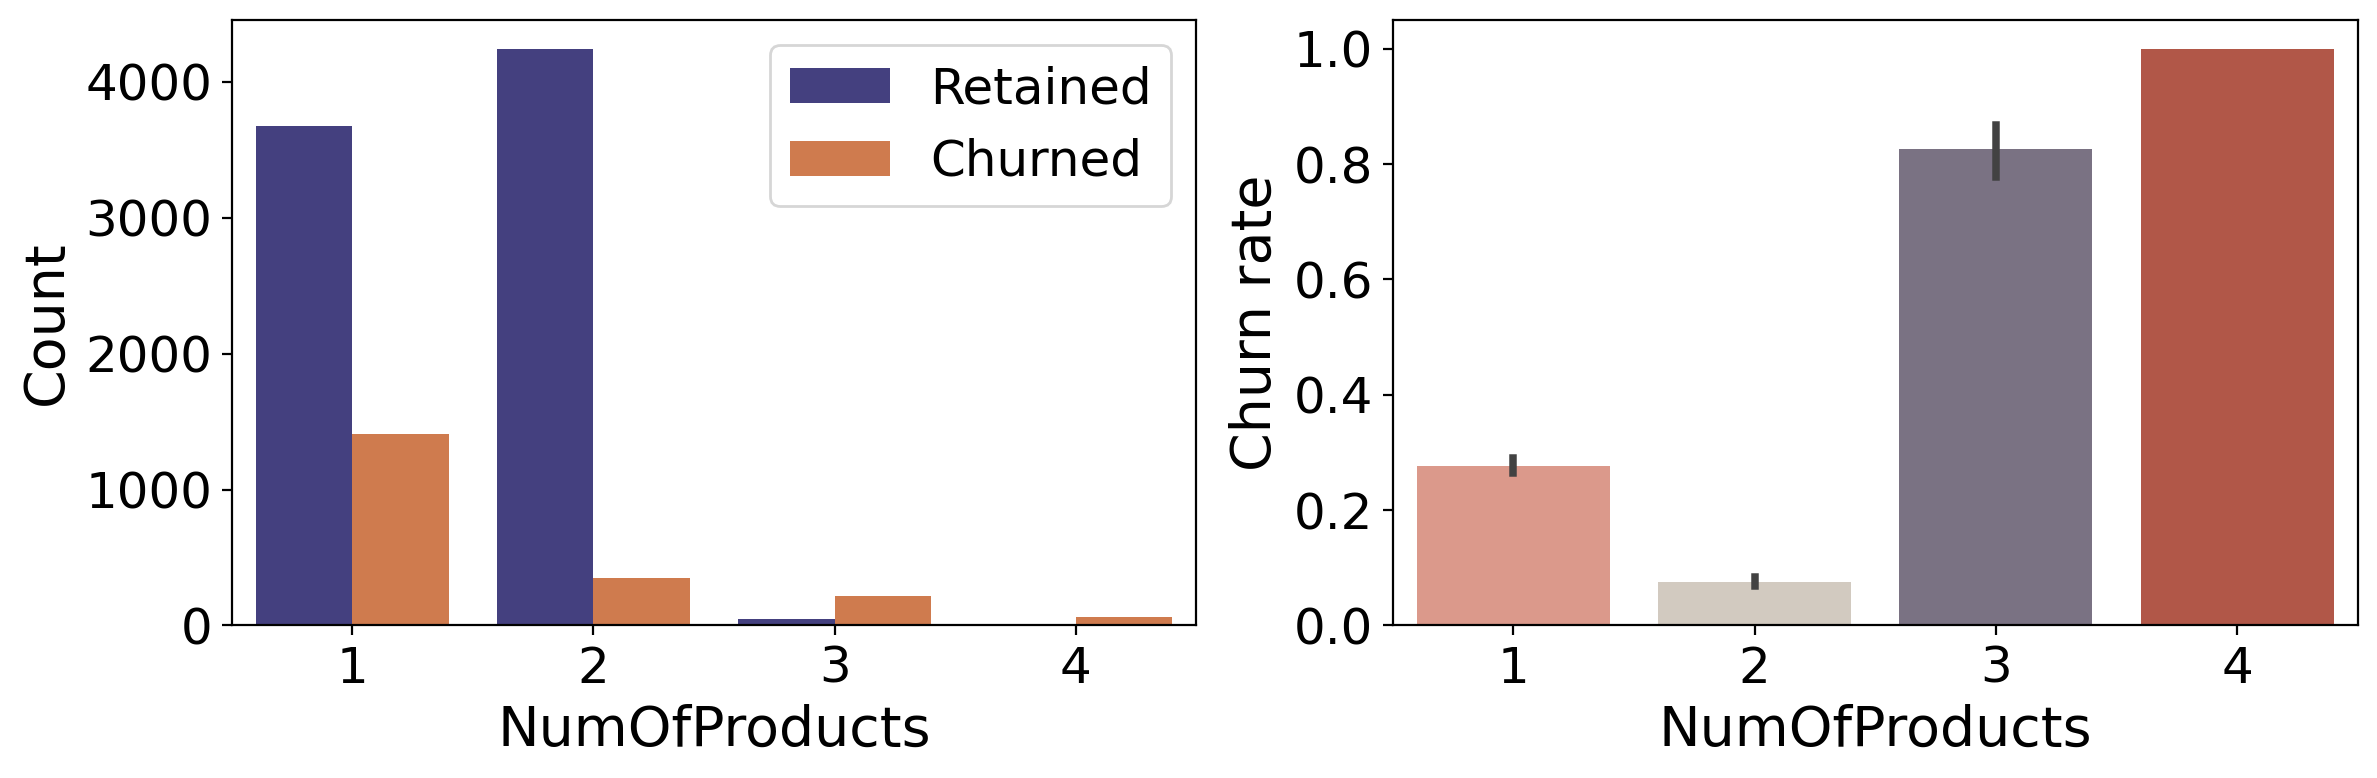

In [ ]:
plot_categorical('NumOfProducts')

### Card Holders

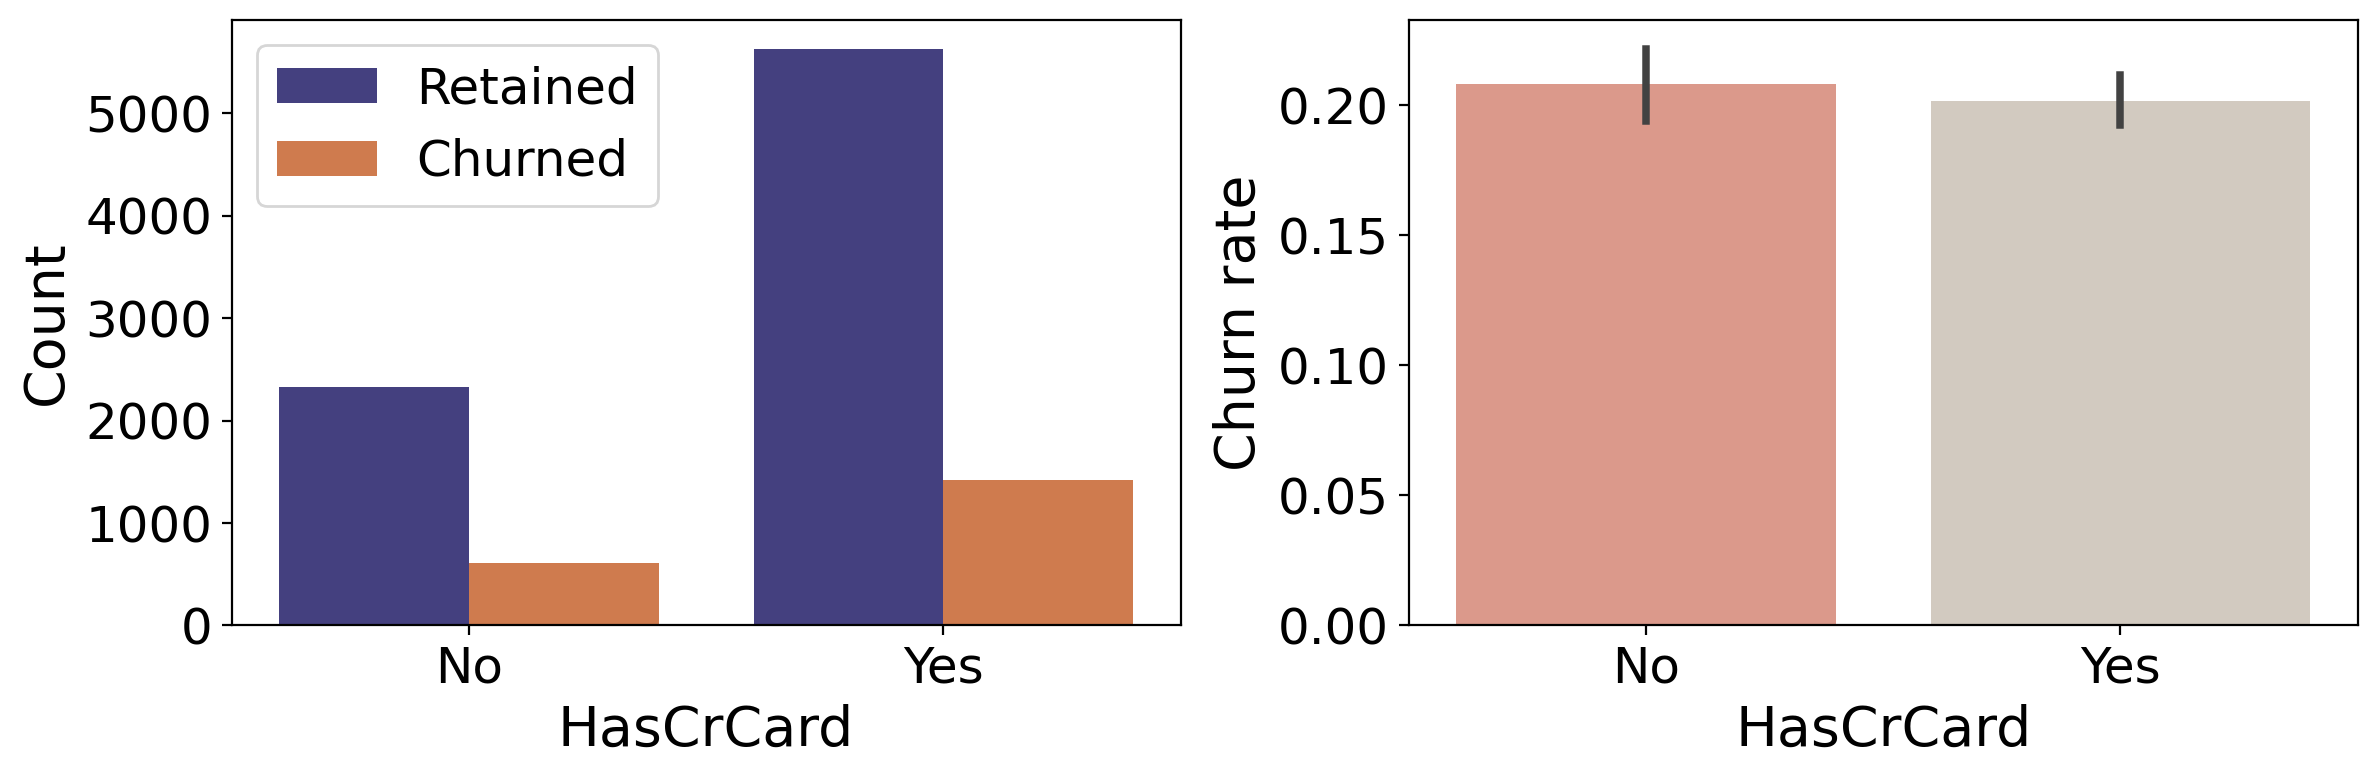

In [ ]:
plot_categorical('HasCrCard')

### Active Members

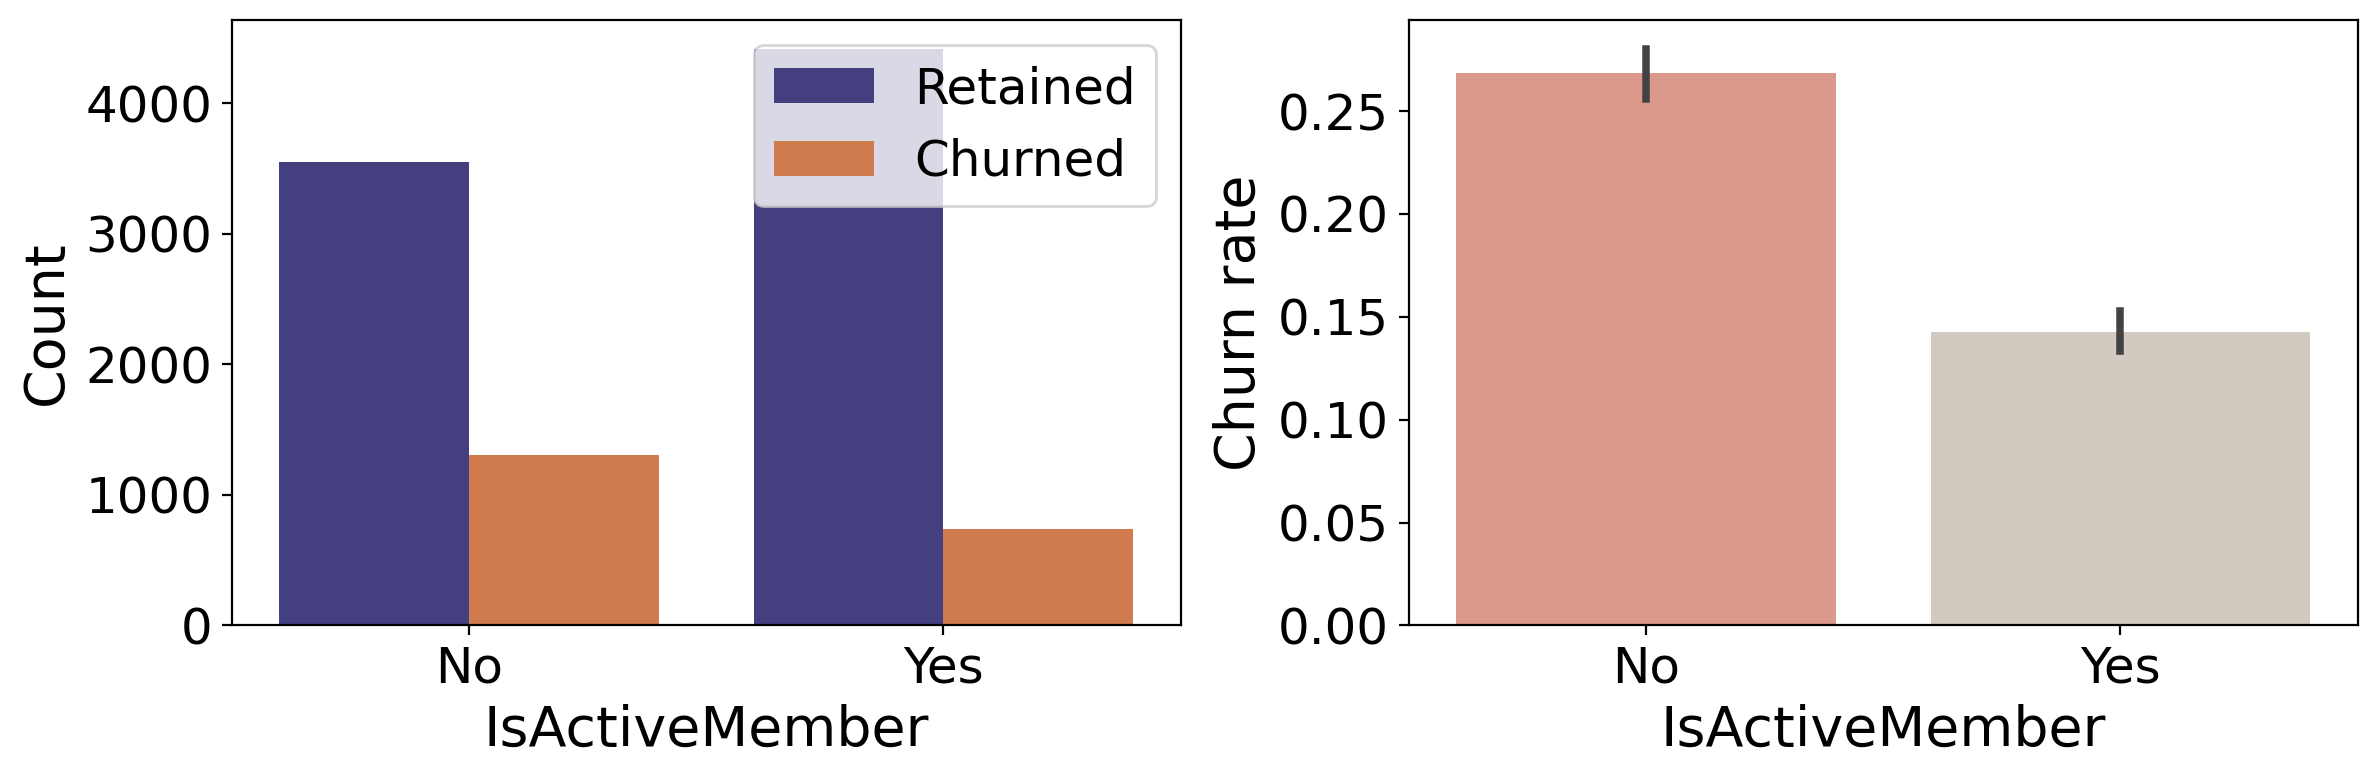

In [ ]:
plot_categorical('IsActiveMember')

## Correlations analysis


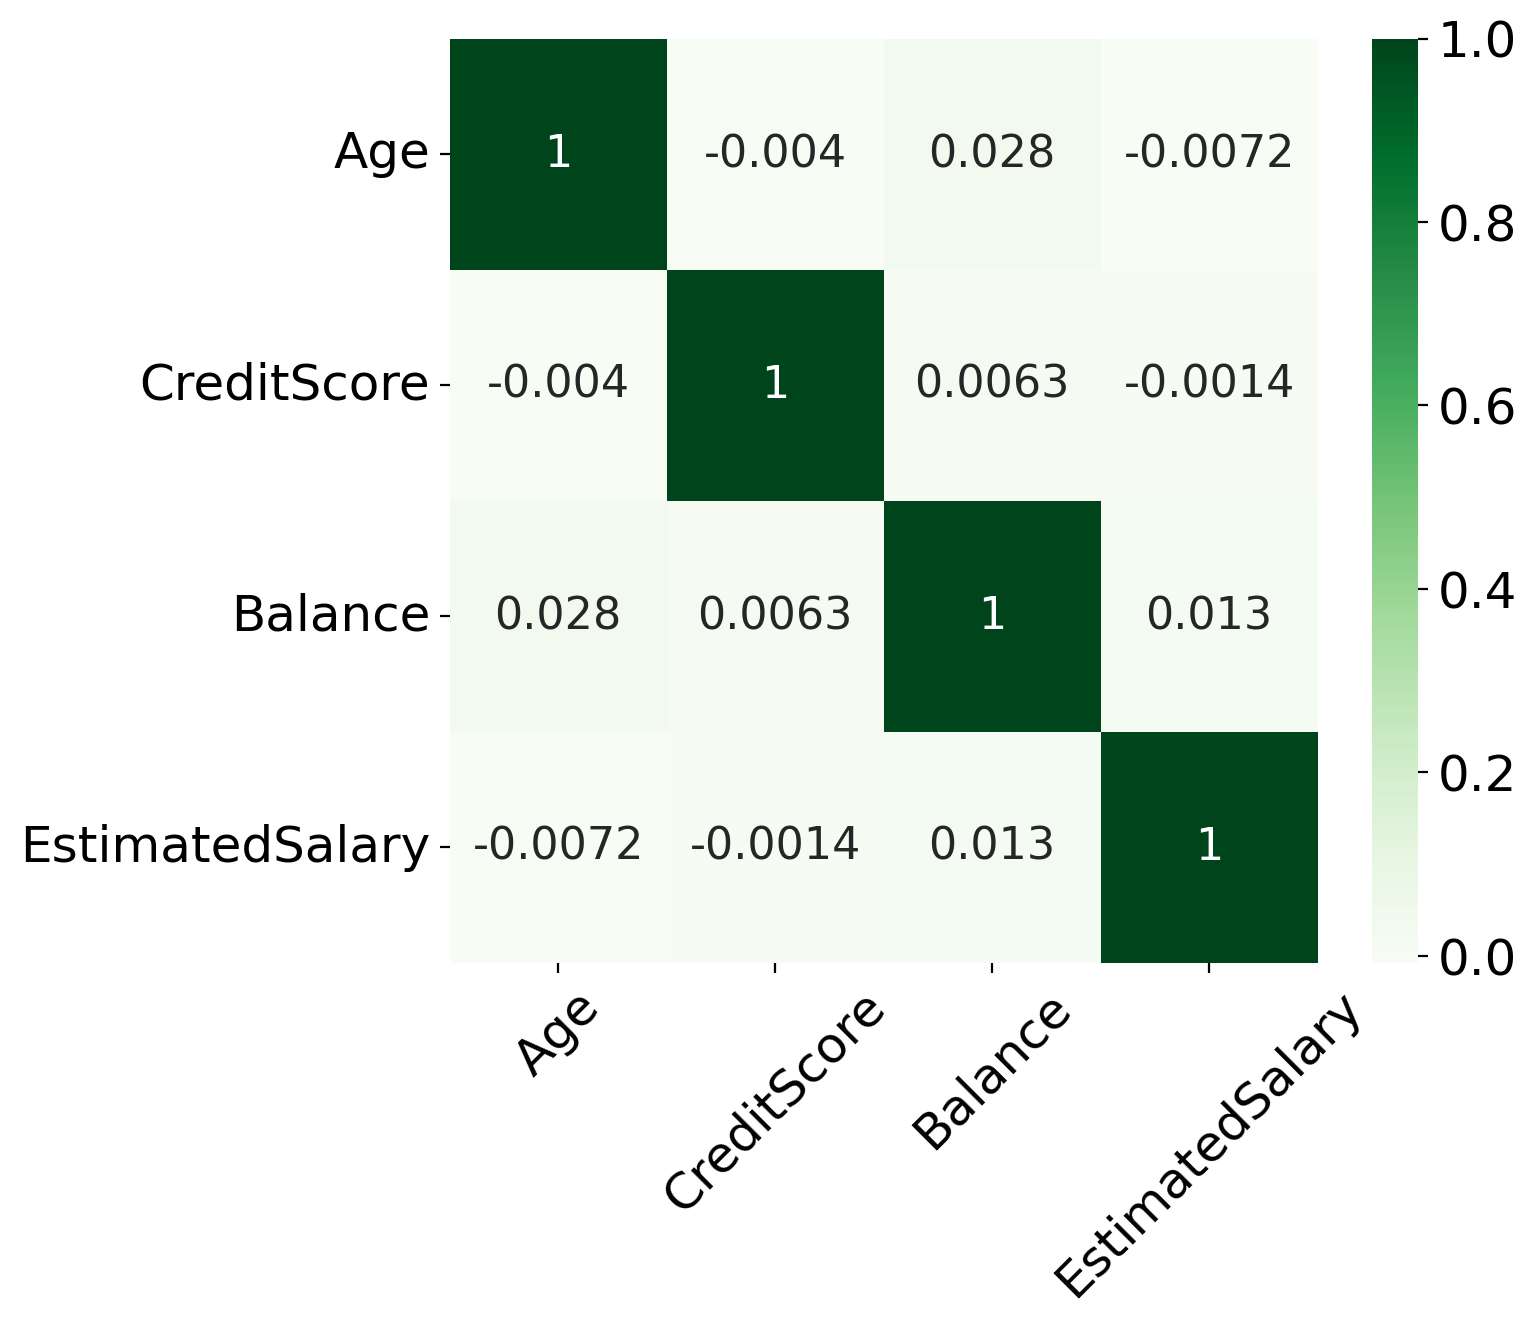

In [ ]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(bankData[continuous].corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Greens',
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360)

### Credit score và EstimatedSalary

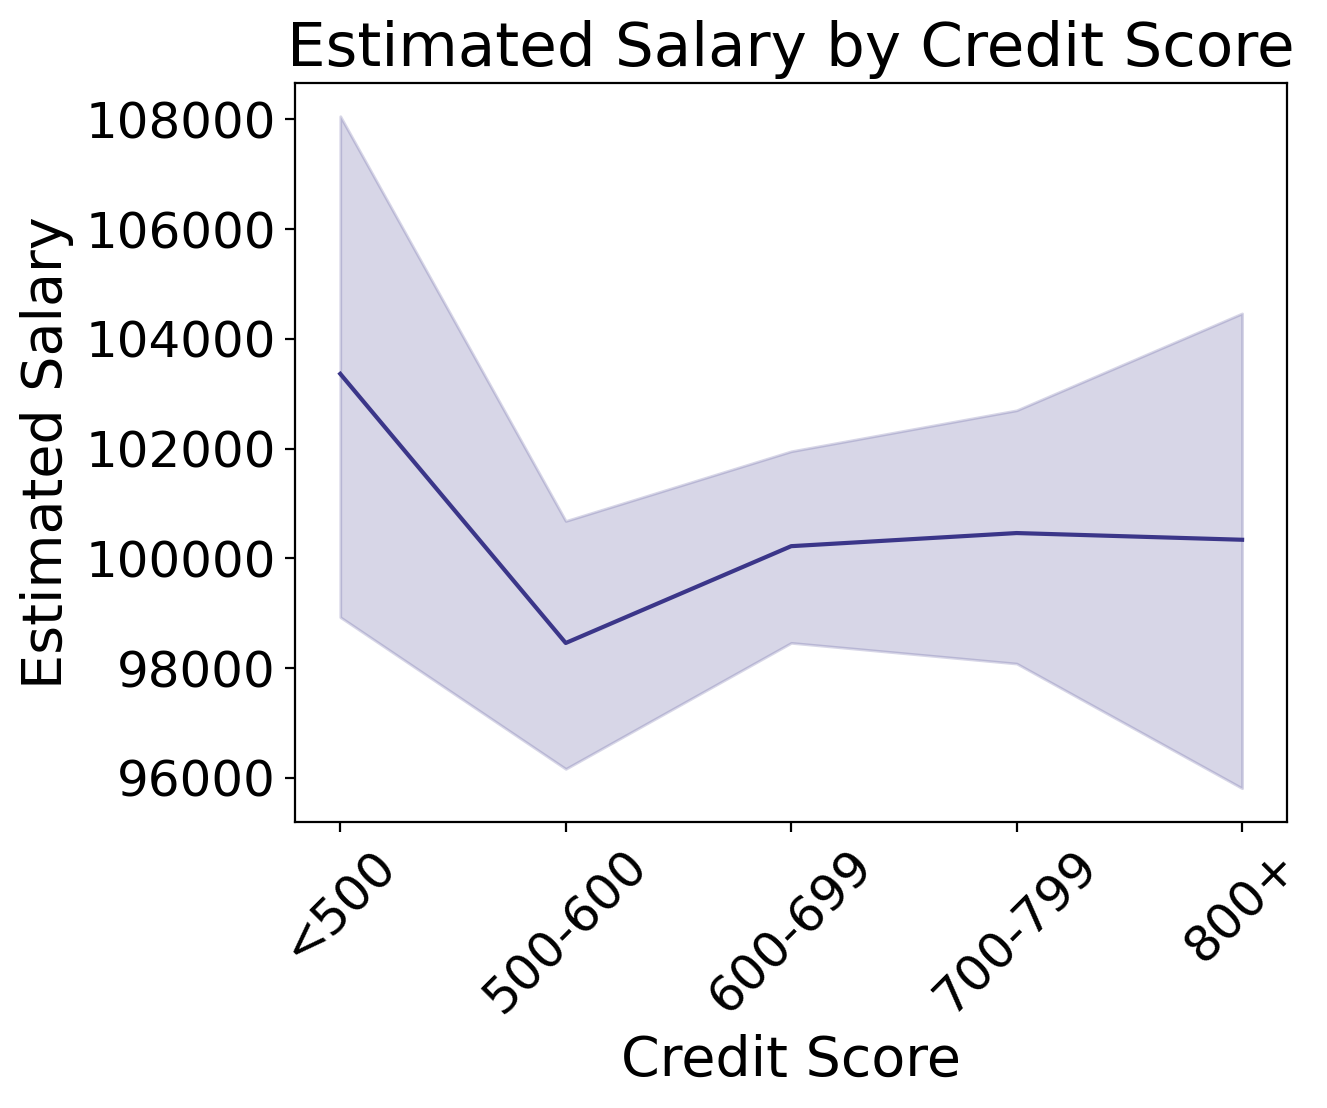

In [ ]:
bins = [350, 500, 599, 699, 799, 850]
group_names = ['<500', '500-600', '600-699', '700-799', '800+']
bankData['CreditScore_bin'] = pd.cut(bankData['CreditScore'], bins=bins, labels=group_names)
sns.lineplot(x="CreditScore_bin", y="EstimatedSalary", data=bankData, color='#3b3689' )
plt.xlabel("Credit Score")
plt.ylabel("Estimated Salary")
plt.title("Estimated Salary by Credit Score")
plt.xticks(rotation=45)
plt.show()


### Credit score và Age

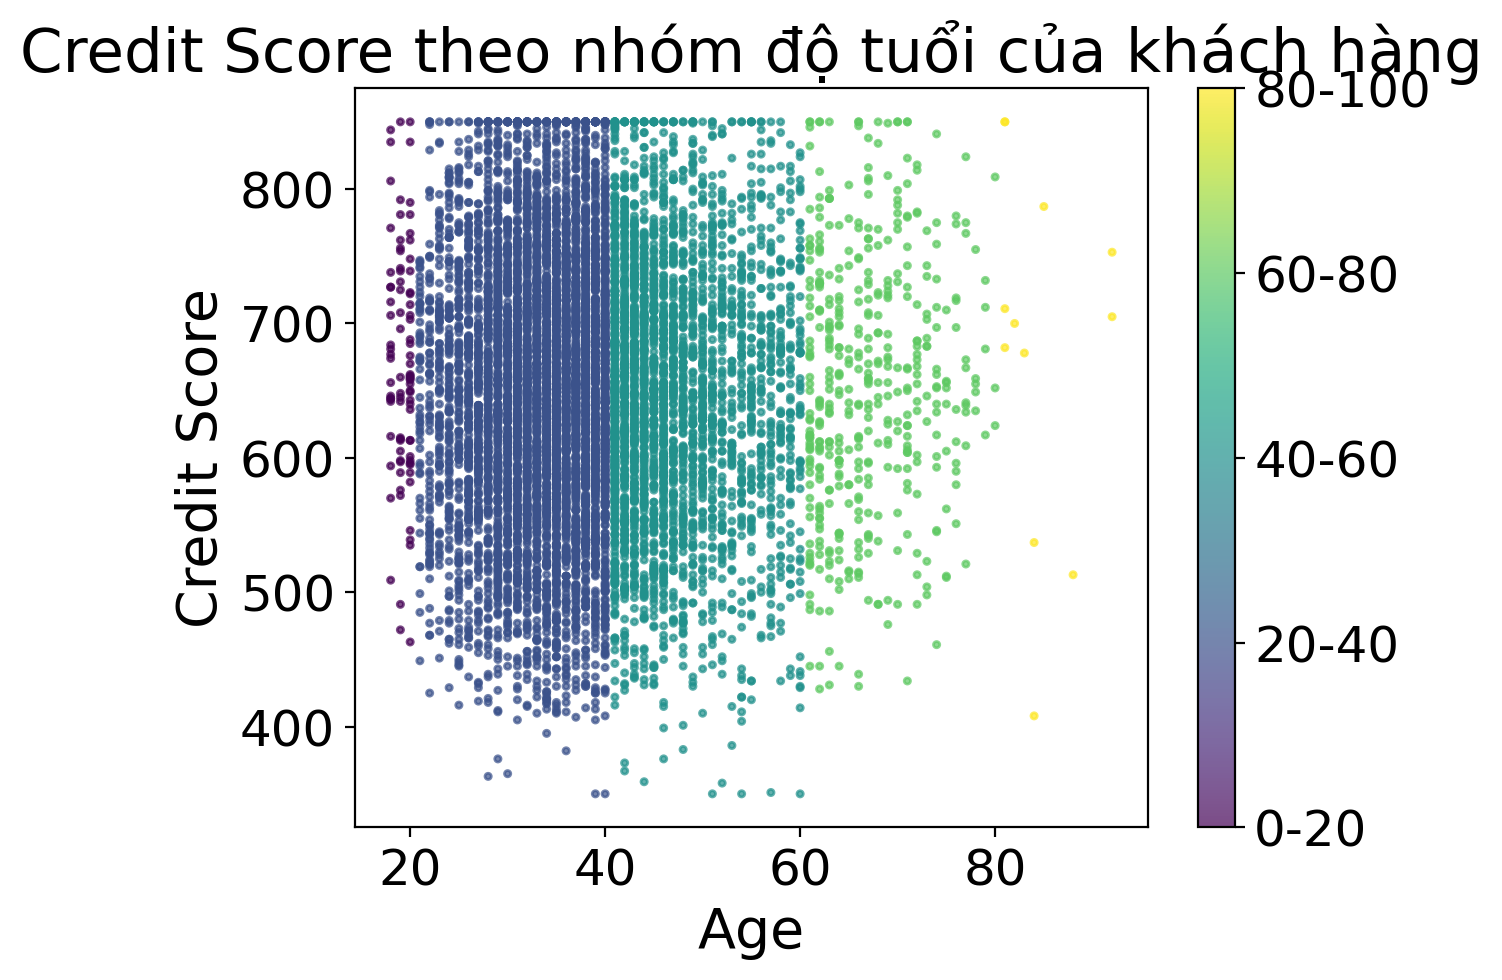

In [ ]:
age_bins = [0, 20, 40, 60, 80, 100]
age_labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
age_groups = pd.cut(bankData['Age'], bins=age_bins, labels=age_labels)

credit_score_mean = bankData.groupby(age_groups)['CreditScore'].mean()

plt.scatter(x=bankData['Age'], y=bankData['CreditScore'], c=age_groups.cat.codes,cmap='viridis', alpha=0.7, s=5)

plt.title('Credit Score theo nhóm độ tuổi của khách hàng')
plt.xlabel('Age')
plt.ylabel('Credit Score')

colorbar = plt.colorbar()
colorbar.set_ticks(range(len(age_labels)))
colorbar.set_ticklabels(age_labels)

plt.show()

### Credit score và Balance

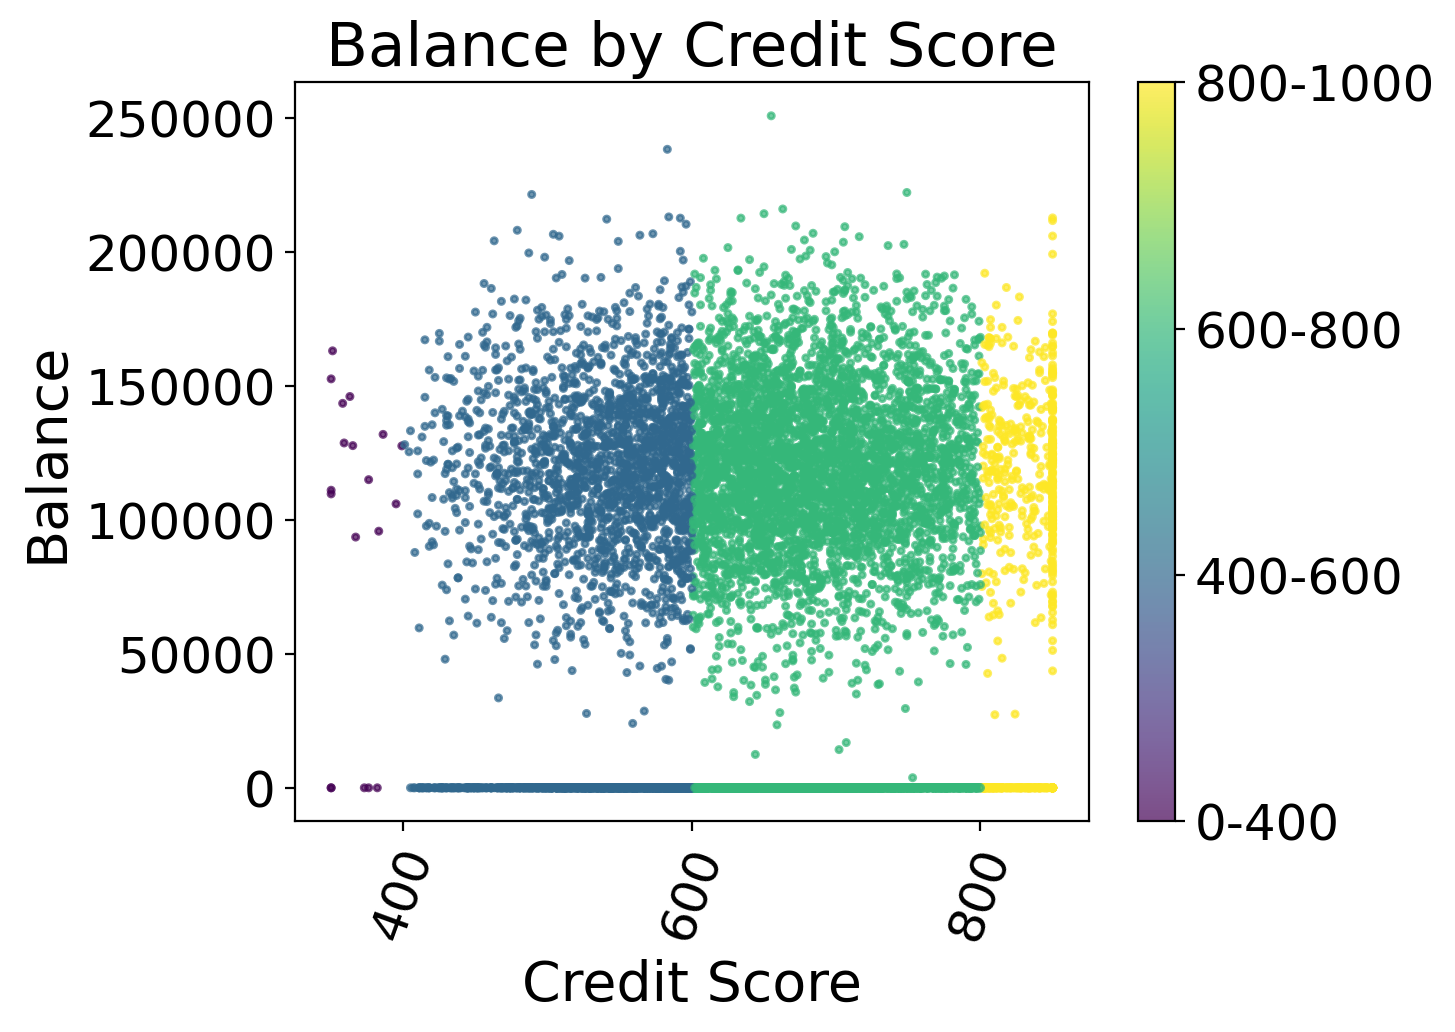

In [ ]:
credit_bins = [0, 400, 600, 800,1000]
credit_labels = ['0-400', '400-600', '600-800','800-1000']
credit_groups = pd.cut(bankData['CreditScore'], bins=credit_bins, labels=credit_labels)
plt.scatter(x="CreditScore", y="Balance", data=bankData,c=credit_groups.cat.codes, cmap='viridis', alpha=0.7, s=5)
plt.xlabel("Credit Score")
plt.ylabel("Balance")
plt.title("Balance by Credit Score")
plt.xticks(rotation = 70)
colorbar = plt.colorbar()
colorbar.set_ticks(range(len(credit_labels)))
colorbar.set_ticklabels(credit_labels)
plt.show()

### Age và Balance

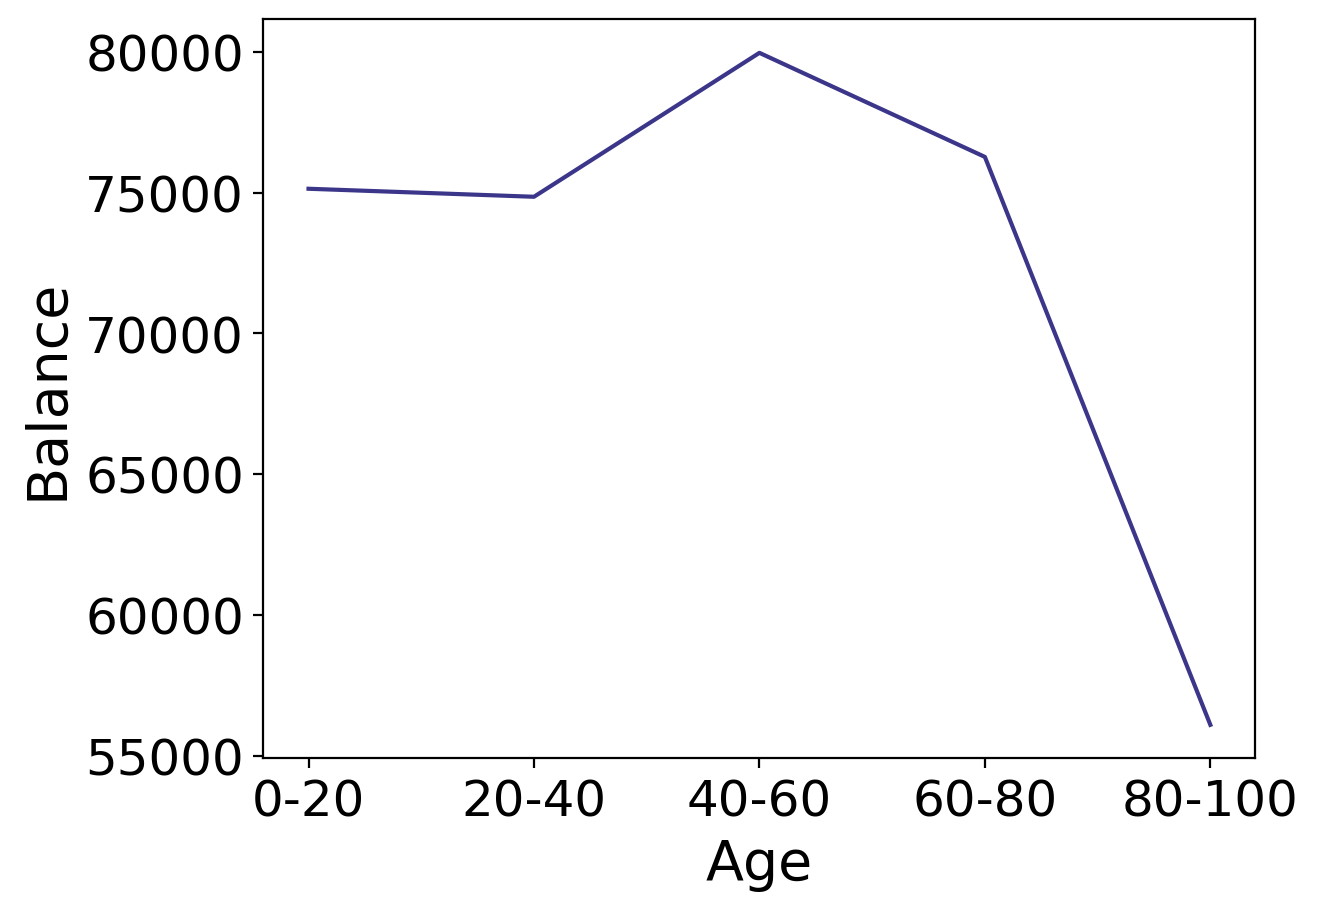

In [ ]:
age_bins = [0, 20, 40, 60, 80, 100]
age_labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
age_groups = pd.cut(bankData['Age'], bins=age_bins, labels=age_labels)

balance_mean = bankData.groupby(age_groups)['Balance'].mean()
plt.plot(age_labels, balance_mean,color='#3b3689' )

plt.xlabel('Age')
plt.ylabel('Balance')

plt.show()

### Age và EstimatedSalary

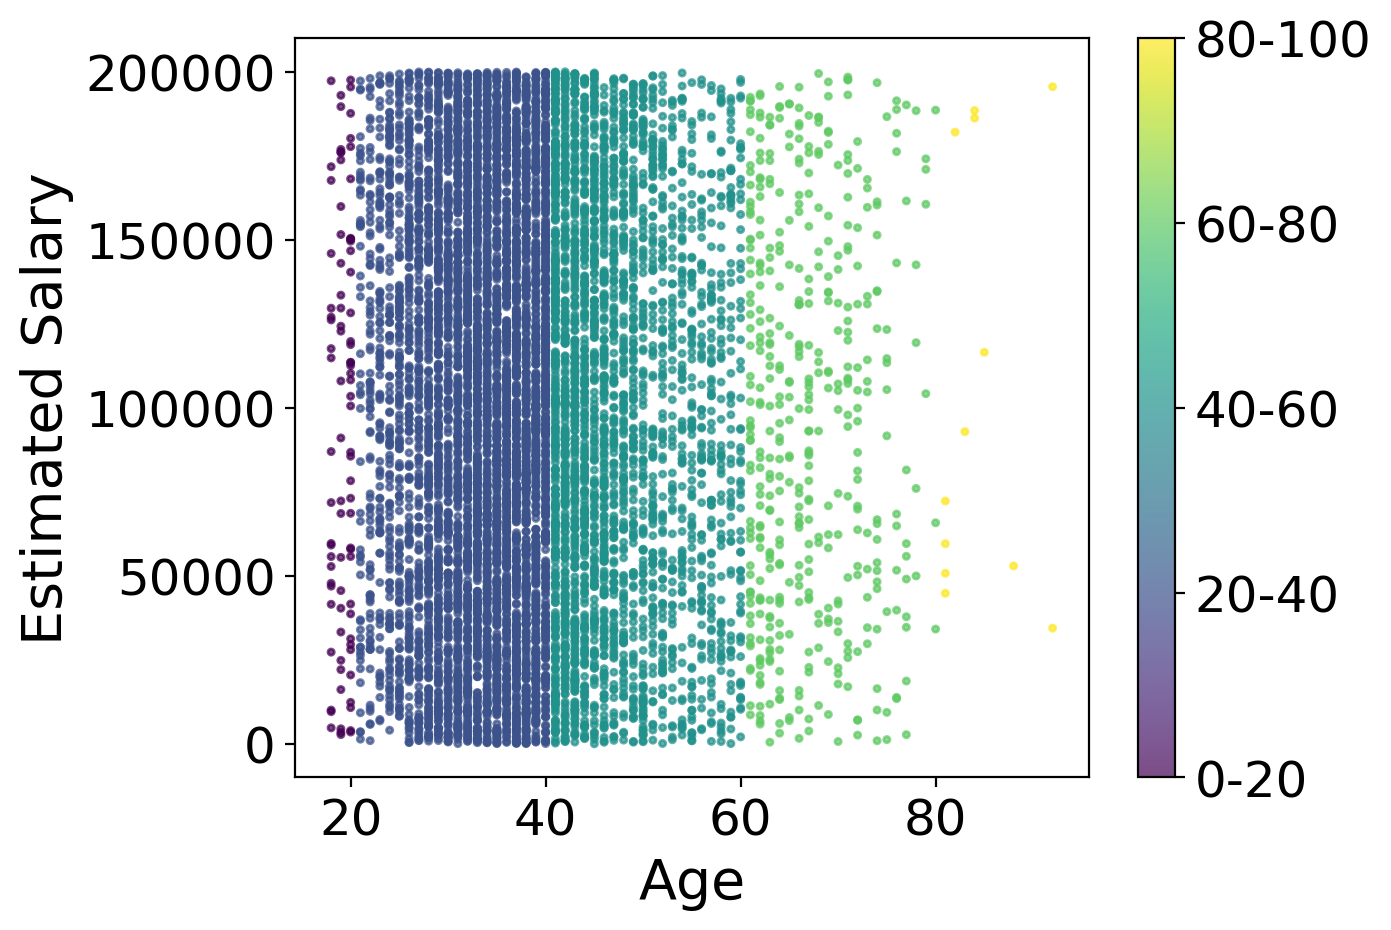

In [ ]:
age_bins = [0, 20, 40, 60, 80, 100]
age_labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
age_groups = pd.cut(bankData['Age'], bins=age_bins, labels=age_labels)

salary_mean = bankData.groupby(age_groups)['EstimatedSalary'].mean()

plt.scatter(x=bankData['Age'], y=bankData['EstimatedSalary'], c=age_groups.cat.codes, cmap='viridis', alpha=0.7, s=5)

plt.xlabel('Age')
plt.ylabel('Estimated Salary')

colorbar = plt.colorbar()
colorbar.set_ticks(range(len(age_labels)))
colorbar.set_ticklabels(age_labels)

plt.show()


### Balance và EstimatedSalary



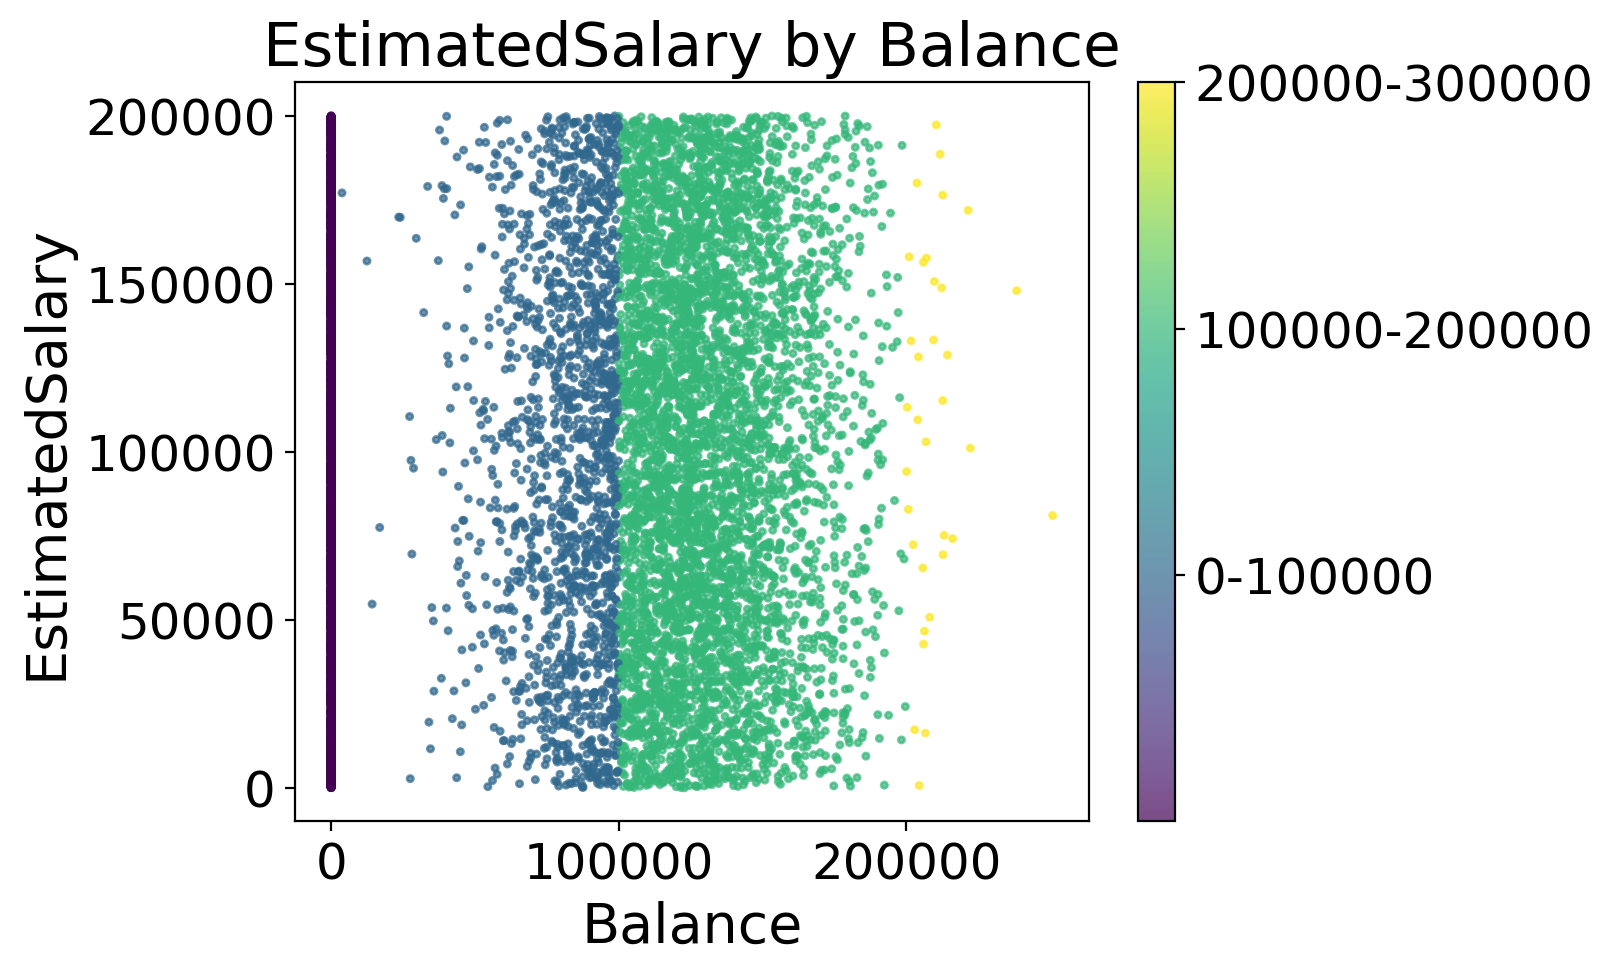

In [ ]:
balance_bins = [0, 100000, 200000,300000]
balance_labels = ['0-100000', '100000-200000','200000-300000']
balance_groups = pd.cut(bankData['Balance'], bins=balance_bins, labels=balance_labels)
plt.scatter(x=bankData['Balance'], y=bankData['EstimatedSalary'],c=balance_groups.cat.codes, cmap='viridis', alpha=0.7, s=5)
plt.xlabel("Balance")
plt.ylabel("EstimatedSalary")
plt.title("EstimatedSalary by Balance")
colorbar = plt.colorbar()
colorbar.set_ticks(range(len(balance_labels)))
colorbar.set_ticklabels(balance_labels)
plt.show()